In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Part 1: Read in the data
* We will use the same files generated for Project 3.

In [4]:
path='ML/payment/'

file_2020q1_OH=pd.read_csv(path+'file_2020Q1_OH.csv')
file_2020q1_VA=pd.read_csv(path+'file_2020Q1_VA.csv')
file_2020q1_GA=pd.read_csv(path+'file_2020Q1_GA.csv')
file_2020q1_MI=pd.read_csv(path+'file_2020Q1_MI.csv')
file_2020q1_CO=pd.read_csv(path+'file_2020Q1_CO.csv')

In [5]:
df=pd.concat([file_2020q1_OH, file_2020q1_VA, file_2020q1_GA, file_2020q1_MI, file_2020q1_CO])
df.shape

(2071611, 108)

In [6]:
df['LOAN_ID'].nunique()

104924

In [7]:
df.columns.tolist()

['POOL_ID',
 'LOAN_ID',
 'ACT_PERIOD',
 'CHANNEL',
 'SELLER',
 'SERVICER',
 'MASTER_SERVICER',
 'ORIG_RATE',
 'CURR_RATE',
 'ORIG_UPB',
 'ISSUANCE_UPB',
 'CURRENT_UPB',
 'ORIG_TERM',
 'ORIG_DATE',
 'FIRST_PAY',
 'LOAN_AGE',
 'REM_MONTHS',
 'ADJ_REM_MONTHS',
 'MATR_DT',
 'OLTV',
 'OCLTV',
 'NUM_BO',
 'DTI',
 'CSCORE_B',
 'CSCORE_C',
 'FIRST_FLAG',
 'PURPOSE',
 'PROP',
 'NO_UNITS',
 'OCC_STAT',
 'STATE',
 'MSA',
 'ZIP',
 'MI_PCT',
 'PRODUCT',
 'PPMT_FLG',
 'IO',
 'FIRST_PAY_IO',
 'MNTHS_TO_AMTZ_IO',
 'DLQ_STATUS',
 'PMT_HISTORY',
 'MOD_FLAG',
 'MI_CANCEL_FLAG',
 'Zero_Bal_Code',
 'ZB_DTE',
 'LAST_UPB',
 'RPRCH_DTE',
 'CURR_SCHD_PRNCPL',
 'TOT_SCHD_PRNCPL',
 'UNSCHD_PRNCPL_CURR',
 'LAST_PAID_INSTALLMENT_DATE',
 'FORECLOSURE_DATE',
 'DISPOSITION_DATE',
 'FORECLOSURE_COSTS',
 'PROPERTY_PRESERVATION_AND_REPAIR_COSTS',
 'ASSET_RECOVERY_COSTS',
 'MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS',
 'ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY',
 'NET_SALES_PROCEEDS',
 'CREDIT_ENHANCEMENT_PROCEEDS',
 'REPUR

# Part 2: Find the loan age when a mortgage gets terminated
* There are two types of termination: 
** voluntary prepayment: rate refinance or cash out refinance
** involuntary prepayment: serious payment default (bucket 6 or above)

### involuntary termination - prepayment default
* Here we will use a very loose definition. 
* Actual termination usually involves foreclosure, which is more serious than no payment received for 6 months. 

In [8]:
df['bad']=np.where(df['DLQ_STATUS'] >= 6, 1, 0)

In [9]:
# find the row with earliest month of 'bad' for each LOAN ID
df_bad=df[df['bad']==1]
df_bad=df_bad.loc[df_bad.groupby('LOAN_ID')['LOAN_AGE'].idxmin()].reset_index()
df_bad=df_bad.drop_duplicates(subset='LOAN_ID', keep='first')

In [10]:
df_bad[['LOAN_ID', 'bad', 'LOAN_AGE']]

,LOAN_ID,bad,LOAN_AGE
0,98836805,1,9.0
1,98837212,1,8.0
2,98838094,1,13.0
3,98838634,1,28.0
4,98838095,1,9.0
...,...,...,...
2546,99518403,1,13.0
2547,99518443,1,8.0
2548,99518840,1,15.0
2549,99519162,1,6.0


In [11]:
df_bad[['LOAN_ID', 'LOAN_AGE', 'bad']].count()

LOAN_ID     2469
LOAN_AGE    2469
bad         2469
dtype: int64

In [12]:
df_bad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2469 entries, 0 to 2550
Columns: 110 entries, index to bad
dtypes: float64(75), int64(13), object(22)
memory usage: 2.1+ MB


In [13]:
# get those loans without 'bad'
df_good=pd.merge(df[['LOAN_ID', 'LOAN_AGE']], df_bad[['LOAN_ID', 'bad']], on='LOAN_ID', how='left')
df_good=df_good[df_good['bad'] != 1]
df_good['bad']=0

In [14]:
df_good.head()

,LOAN_ID,LOAN_AGE,bad
0,98836743,0.0,0
1,98836743,1.0,0
2,98836743,2.0,0
3,98836743,3.0,0
4,98836743,4.0,0


In [15]:
# find the maximum loan age for good accounts
df_good=df_good.loc[df_good.groupby('LOAN_ID')['LOAN_AGE'].idxmax()].reset_index()
df_good=df_good.drop_duplicates(subset='LOAN_ID', keep='first')

In [16]:
df_good[['LOAN_ID', 'LOAN_AGE', 'bad']].count()

LOAN_ID     102455
LOAN_AGE    102455
bad         102455
dtype: int64

In [17]:
df_good['LOAN_AGE'].count()

102455

In [18]:
# stack two files
df_bad=pd.concat([df_good, df_bad[['LOAN_ID', 'bad', 'LOAN_AGE']]]).reset_index(drop=True)

In [19]:
df_bad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104924 entries, 0 to 104923
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   index     102455 non-null  float64
 1   LOAN_ID   104924 non-null  int64  
 2   LOAN_AGE  104924 non-null  float64
 3   bad       104924 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 3.2 MB


In [20]:
df_bad['LOAN_ID'].nunique()

104924

In [21]:
df_bad['bad'].count()

104924

In [22]:
df_bad.head()

,index,LOAN_ID,LOAN_AGE,bad
0,1107557.0,98836742,9.0,0
1,7.0,98836743,7.0,0
2,33.0,98836744,23.0,0
3,1586592.0,98836781,25.0,0
4,1107585.0,98836789,26.0,0


In [23]:
df_bad['LOAN_AGE']=np.where(df_bad['LOAN_AGE'] < 0, 0, df_bad['LOAN_AGE'])

# make a copy of the file
df_bad=df_bad.copy()

### voluntary termination - prepayment

In [24]:
df.groupby('Zero_Bal_Code')['LOAN_ID'].count()

Zero_Bal_Code
1.0     54061
2.0         3
6.0        98
9.0         4
16.0        5
Name: LOAN_ID, dtype: int64

In [25]:
df['prepaid']=np.where(df['Zero_Bal_Code'] > 0, 1, 0)


In [26]:
# find the row with earliest month of complete prepayment for each LOAN ID
#This code causes error, to demostate troubleshooting
df_prepaid=df[df['prepaid']==1]
#df_prepaid=df_prepaid.loc[df_prepaid.groupby('LOAN_ID')['LOAN_AGE'].idxmin()].reset_index()
#df_prepaid=df_prepaid.drop_duplicates(subset='LOAN_ID', keep='first')

In [27]:
df.head()

,POOL_ID,LOAN_ID,ACT_PERIOD,CHANNEL,SELLER,SERVICER,MASTER_SERVICER,ORIG_RATE,CURR_RATE,ORIG_UPB,...,PLAN_NUMBER,FORBEARANCE_INDICATOR,HIGH_LOAN_TO_VALUE_HLTV_REFINANCE_OPTION_INDICATOR,DEAL_NAME,RE_PROCS_FLAG,ADR_TYPE,ADR_COUNT,ADR_UPB,bad,prepaid
0,NaN,98836743,12020,R,Other,Other,NaN,3.625,3.625,207000.0,...,NaN,7,N,NaN,NaN,7,NaN,NaN,0,0
1,NaN,98836743,22020,R,Other,Other,NaN,3.625,3.625,207000.0,...,NaN,7,N,NaN,NaN,7,NaN,NaN,0,0
2,NaN,98836743,32020,R,Other,Other,NaN,3.625,3.625,207000.0,...,NaN,7,N,NaN,NaN,7,NaN,NaN,0,0
3,NaN,98836743,42020,R,Other,Other,NaN,3.625,3.625,207000.0,...,NaN,7,N,NaN,NaN,7,NaN,NaN,0,0
4,NaN,98836743,52020,R,Other,Other,NaN,3.625,3.625,207000.0,...,NaN,7,N,NaN,NaN,7,NaN,NaN,0,0


In [28]:
# check the error message above
df_prepaid[['LOAN_ID', 'prepaid', "LOAN_AGE"]]

,LOAN_ID,prepaid,LOAN_AGE
8,98836743,1,NaN
34,98836744,1,NaN
71,98836862,1,NaN
104,98837003,1,NaN
130,98837058,1,NaN
...,...,...,...
484972,99520288,1,NaN
484980,99520330,1,NaN
484990,99520350,1,NaN
485008,99520391,1,NaN


In [29]:
# select a few accounts to find out why LOAN_AGE=Nan
df[df['LOAN_ID']==98836743][['LOAN_ID', 'LOAN_AGE', 'ORIG_UPB', 'CURRENT_UPB', 'Zero_Bal_Code']]

,LOAN_ID,LOAN_AGE,ORIG_UPB,CURRENT_UPB,Zero_Bal_Code
0,98836743,0.0,207000.0,206411.45,NaN
1,98836743,1.0,207000.0,205821.12,NaN
2,98836743,2.0,207000.0,205229.01,NaN
3,98836743,3.0,207000.0,204635.11,NaN
4,98836743,4.0,207000.0,204039.42,NaN
5,98836743,5.0,207000.0,203441.93,NaN
6,98836743,6.0,207000.0,203000.00,NaN
7,98836743,7.0,207000.0,202842.63,NaN
8,98836743,NaN,207000.0,0.00,1.0


In [30]:
df[df['LOAN_ID']==98836744][['LOAN_ID', 'LOAN_AGE', 'ORIG_UPB', 'CURRENT_UPB', 'Zero_Bal_Code']]

,LOAN_ID,LOAN_AGE,ORIG_UPB,CURRENT_UPB,Zero_Bal_Code
9,98836744,-1.0,215000.0,215000.00,NaN
10,98836744,0.0,215000.0,215000.00,NaN
11,98836744,1.0,215000.0,214383.86,NaN
12,98836744,2.0,215000.0,213765.86,NaN
13,98836744,3.0,215000.0,213145.99,NaN
14,98836744,4.0,215000.0,212524.25,NaN
15,98836744,5.0,215000.0,212000.00,NaN
16,98836744,6.0,215000.0,211000.00,NaN
17,98836744,7.0,215000.0,210647.74,NaN
18,98836744,8.0,215000.0,209968.46,NaN


* Finding: when the loan is paid off, LOAN_AGE becomes zero
* We can use (preiouvs LOAN_AGE)+1 as the LOAN_AGE for complete prepayment

In [31]:
df_prepaid=df[df['prepaid']==1]
df_prepaid.drop_duplicates(subset='LOAN_AGE', keep='first')

df_prepaid=pd.merge(df_prepaid[['LOAN_ID']], df, on='LOAN_ID', how='left')

df_prepaid=df_prepaid.groupby('LOAN_ID')['LOAN_AGE'].max().reset_index()
df_prepaid['LOAN_AGE']=df_prepaid['LOAN_AGE']+1

df_prepaid.head()

,LOAN_ID,LOAN_AGE
0,98836742,10.0
1,98836743,8.0
2,98836744,24.0
3,98836799,5.0
4,98836817,14.0


In [32]:
# carve out those loans that have not been prepaid          
df_unprepaid=pd.merge(df_prepaid[['LOAN_ID']].assign(prepaid=1), df[['LOAN_ID', 'LOAN_AGE']], on='LOAN_ID', how='right')

In [33]:
df_unprepaid.head()

,LOAN_ID,prepaid,LOAN_AGE
0,98836743,1.0,0.0
1,98836743,1.0,1.0
2,98836743,1.0,2.0
3,98836743,1.0,3.0
4,98836743,1.0,4.0


In [34]:
df_unprepaid=df_unprepaid[df_unprepaid['prepaid'].isnull()==True]

df_unprepaid=df_unprepaid.groupby('LOAN_ID')['LOAN_AGE'].max().reset_index()
df_unprepaid['prepaid']=0
df_unprepaid.head()

,LOAN_ID,LOAN_AGE,prepaid
0,98836781,25.0,0
1,98836789,26.0,0
2,98836796,25.0,0
3,98836805,25.0,0
4,98836823,26.0,0


In [35]:
df_unprepaid.describe()

,LOAN_ID,LOAN_AGE,prepaid
count,5.075300e+04,50753.000000,50753.0
mean,9.918886e+07,24.998995,0.0
std,1.970546e+05,1.367384,0.0
min,9.883678e+07,23.000000,0.0
25%,9.901876e+07,24.000000,0.0
50%,9.919525e+07,25.000000,0.0
75%,9.935945e+07,26.000000,0.0
max,9.952048e+07,36.000000,0.0


In [36]:
print(df_prepaid.shape)
print(df_unprepaid.shape)

(54171, 2)
(50753, 3)


In [37]:
df_prepaid=pd.concat([df_prepaid.assign(prepaid=1), df_unprepaid])
df_prepaid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104924 entries, 0 to 50752
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   LOAN_ID   104924 non-null  int64  
 1   LOAN_AGE  104924 non-null  float64
 2   prepaid   104924 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 3.2 MB


In [38]:
df_prepaid.describe()

,LOAN_ID,LOAN_AGE,prepaid
count,1.049240e+05,104924.000000,104924.000000
mean,9.917922e+07,18.894581,0.516288
std,1.970199e+05,7.236594,0.499737
min,9.883674e+07,0.000000,0.000000
25%,9.900946e+07,12.000000,0.000000
50%,9.918055e+07,23.000000,1.000000
75%,9.934903e+07,25.000000,1.000000
max,9.952048e+07,66.000000,1.000000


In [39]:
df_prepaid.head()

,LOAN_ID,LOAN_AGE,prepaid
0,98836742,10.0,1
1,98836743,8.0,1
2,98836744,24.0,1
3,98836799,5.0,1
4,98836817,14.0,1


In [40]:
df_bad.head()

,index,LOAN_ID,LOAN_AGE,bad
0,1107557.0,98836742,9.0,0
1,7.0,98836743,7.0,0
2,33.0,98836744,23.0,0
3,1586592.0,98836781,25.0,0
4,1107585.0,98836789,26.0,0


### Merge two files

In [41]:
df_survival=pd.merge(df_bad.rename(columns={'LOAN_AGE': 'loan_age_bad'}),
                     df_prepaid.rename(columns={'LOAN_AGE': 'loan_age_prepaid'}), 
                     on='LOAN_ID', how='inner')

In [42]:
df_survival.head()

,index,LOAN_ID,loan_age_bad,bad,loan_age_prepaid,prepaid
0,1107557.0,98836742,9.0,0,10.0,1
1,7.0,98836743,7.0,0,8.0,1
2,33.0,98836744,23.0,0,24.0,1
3,1586592.0,98836781,25.0,0,25.0,0
4,1107585.0,98836789,26.0,0,26.0,0


In [43]:
df_survival.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104924 entries, 0 to 104923
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             102455 non-null  float64
 1   LOAN_ID           104924 non-null  int64  
 2   loan_age_bad      104924 non-null  float64
 3   bad               104924 non-null  int64  
 4   loan_age_prepaid  104924 non-null  float64
 5   prepaid           104924 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 5.6 MB


In [44]:
df_nodup=df.drop_duplicates(subset='LOAN_ID', keep='first')

df_survival=pd.merge(df_survival, df_nodup[['LOAN_ID', "ORIG_RATE", "CURR_RATE", "ORIG_UPB", "ORIG_TERM",  
                                            "OLTV", "OCLTV", "DTI", "CSCORE_B", "PURPOSE", "PROP", "STATE"]])

In [45]:
df_survival.describe().T

,count,mean,std,min,25%,50%,75%,max
index,102455.0,1.070858e+06,600998.281325,7.000000e+00,549687.00,1084844.00,1.604296e+06,2071609.0
LOAN_ID,104924.0,9.917922e+07,197019.945107,9.883674e+07,99009455.75,99180553.50,9.934903e+07,99520476.0
loan_age_bad,104924.0,1.808653e+01,7.702378,0.000000e+00,11.00,22.00,2.500000e+01,65.0
bad,104924.0,2.353132e-02,0.151584,0.000000e+00,0.00,0.00,0.000000e+00,1.0
loan_age_prepaid,104924.0,1.889458e+01,7.236594,0.000000e+00,12.00,23.00,2.500000e+01,66.0
prepaid,104924.0,5.162880e-01,0.499737,0.000000e+00,0.00,1.00,1.000000e+00,1.0
ORIG_RATE,104924.0,3.808843e+00,0.451864,2.375000e+00,3.50,3.75,3.999000e+00,6.5
CURR_RATE,104924.0,3.808843e+00,0.451864,2.375000e+00,3.50,3.75,3.999000e+00,6.5
ORIG_UPB,104924.0,2.537213e+05,123826.341576,1.000000e+04,156000.00,237000.00,3.350000e+05,800000.0
ORIG_TERM,104924.0,3.196551e+02,72.642681,9.600000e+01,324.00,360.00,3.600000e+02,360.0


* All mortgages were originated in Q1 2020. By Q3 2022 they are no more than 30 months old.
* Loans showing age > 30 are considered to be data error and should be excluded. 

In [46]:
df_survival.describe(percentiles=(0.90, 0.95, 0.99, 0.995, 0.999, 1)).T

,count,mean,std,min,50%,90%,95%,99%,99.5%,99.9%,100%,max
index,102455.0,1.070858e+06,600998.281325,7.000000e+00,1084844.00,1.884493e+06,1.978556e+06,2052865.96,2.062121e+06,2.069717e+06,2071609.0,2071609.0
LOAN_ID,104924.0,9.917922e+07,197019.945107,9.883674e+07,99180553.50,9.945219e+07,9.948628e+07,99513795.70,9.951707e+07,9.951968e+07,99520476.0,99520476.0
loan_age_bad,104924.0,1.808653e+01,7.702378,0.000000e+00,22.00,2.600000e+01,2.700000e+01,28.00,2.900000e+01,3.000000e+01,65.0,65.0
bad,104924.0,2.353132e-02,0.151584,0.000000e+00,0.00,0.000000e+00,0.000000e+00,1.00,1.000000e+00,1.000000e+00,1.0,1.0
loan_age_prepaid,104924.0,1.889458e+01,7.236594,0.000000e+00,23.00,2.600000e+01,2.700000e+01,28.00,2.900000e+01,3.000000e+01,66.0,66.0
prepaid,104924.0,5.162880e-01,0.499737,0.000000e+00,1.00,1.000000e+00,1.000000e+00,1.00,1.000000e+00,1.000000e+00,1.0,1.0
ORIG_RATE,104924.0,3.808843e+00,0.451864,2.375000e+00,3.75,4.375000e+00,4.625000e+00,5.25,5.500000e+00,5.750000e+00,6.5,6.5
CURR_RATE,104924.0,3.808843e+00,0.451864,2.375000e+00,3.75,4.375000e+00,4.625000e+00,5.25,5.500000e+00,5.750000e+00,6.5,6.5
ORIG_UPB,104924.0,2.537213e+05,123826.341576,1.000000e+04,237000.00,4.310000e+05,4.840000e+05,572000.00,6.230000e+05,7.260000e+05,800000.0,800000.0
ORIG_TERM,104924.0,3.196551e+02,72.642681,9.600000e+01,360.00,3.600000e+02,3.600000e+02,360.00,3.600000e+02,3.600000e+02,360.0,360.0


In [47]:
df_survival[(df_survival['loan_age_bad'] > 30) | (df_survival['loan_age_prepaid'] > 30) ]['LOAN_ID'].count()

80

In [48]:
# data cleaning
df_survival=df_survival[(df_survival['loan_age_bad'] <= 30) & (df_survival['loan_age_prepaid'] <= 30) 
                       & (df_survival['CSCORE_B'] > 0) & (df_survival['DTI'] > 0)]

df_survival.shape

(104791, 17)

In [49]:
#### Split to modeling sample and validation sample
df_survival['random']=np.random.uniform(0, 1, len(df_survival['LOAN_ID']))
df_survival['seg']=np.where(df_survival['random'] > 0.3, 'mod', 'val')

df_mod=df_survival[df_survival['seg']=='mod']
df_val=df_survival[df_survival['seg']=='val']

df_survival.groupby('seg')['LOAN_ID'].count()

seg
mod    73333
val    31458
Name: LOAN_ID, dtype: int64

In [50]:
df_mod

,index,LOAN_ID,loan_age_bad,bad,loan_age_prepaid,prepaid,ORIG_RATE,CURR_RATE,ORIG_UPB,ORIG_TERM,OLTV,OCLTV,DTI,CSCORE_B,PURPOSE,PROP,STATE,random,seg
0,1107557.0,98836742,9.0,0,10.0,1,3.375,3.375,308000.0,180,75,75,38.0,796.0,P,SF,MI,0.418810,mod
1,7.0,98836743,7.0,0,8.0,1,3.625,3.625,207000.0,240,66,66,25.0,806.0,R,SF,OH,0.753384,mod
3,1586592.0,98836781,25.0,0,25.0,0,3.750,3.750,286000.0,360,79,79,39.0,789.0,R,SF,CO,0.573129,mod
4,1107585.0,98836789,26.0,0,26.0,0,3.990,3.990,222000.0,360,78,78,43.0,681.0,R,SF,MI,0.962968,mod
5,1586619.0,98836796,25.0,0,25.0,0,3.999,3.999,243000.0,360,79,79,43.0,769.0,C,SF,CO,0.918518,mod
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104918,NaN,99517875,6.0,1,23.0,0,3.500,3.500,276000.0,360,95,95,41.0,763.0,P,PU,GA,0.909186,mod
104919,NaN,99518403,13.0,1,15.0,1,3.875,3.875,260000.0,360,78,78,30.0,755.0,R,SF,CO,0.563761,mod
104920,NaN,99518443,8.0,1,25.0,0,3.625,3.625,170000.0,360,97,97,40.0,772.0,P,PU,GA,0.818122,mod
104922,NaN,99519162,6.0,1,17.0,1,3.990,3.990,315000.0,360,97,97,31.0,766.0,P,SF,MI,0.406625,mod


In [51]:
#df_mod=df_survival[df_survival['STATE'] != 'CO']
#df_val=df_survival[df_survival['STATE']=='CO']

# Part 3 - Kaplan-Meier Curve for Risk
* The curve provides a probability estimate of when an event will target.  
* It has two dimensions: probability of occurence, time needed to the occurrence.
* However, it is an estimate by group.  It does not provide record-level estimate. 

In [52]:
#! pip install lifelines

In [53]:
T=df_mod['loan_age_bad']
E=df_mod['bad']

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
1.0,1.000000
2.0,1.000000
3.0,1.000000
4.0,1.000000
5.0,1.000000
6.0,0.997522
7.0,0.994047
8.0,0.989103


The median survival time : inf


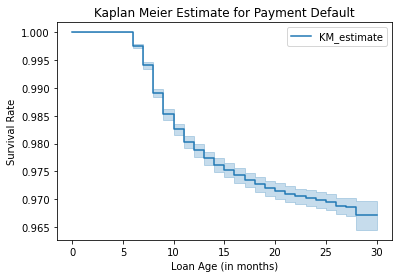

In [54]:
kmf.plot_survival_function()
plt.title("Kaplan Meier Estimate for Payment Default")
plt.xlabel("Loan Age (in months)")
plt.ylabel("Survival Rate")

print("The median survival time :",kmf.median_survival_time_)

In [55]:
df_mod.groupby('PURPOSE')['LOAN_ID'].count()

PURPOSE
C    18632
P    26058
R    28643
Name: LOAN_ID, dtype: int64

Text(0, 0.5, 'Survival')

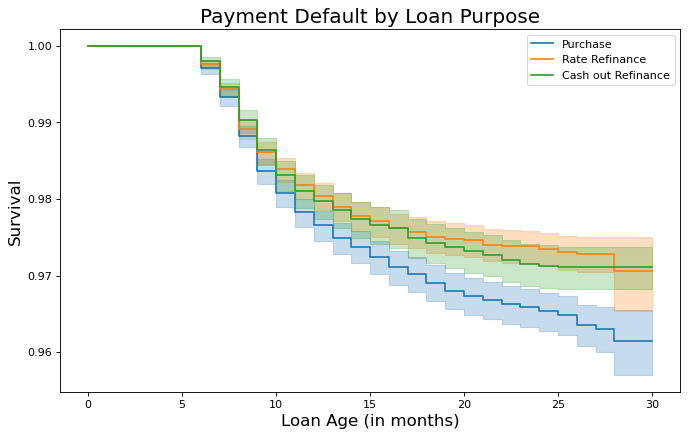

In [56]:
# payment default by loan purpose

loan_age='loan_age_bad'
y='bad'

figure(figsize=(10, 6), dpi=80)
ax = plt.subplot(111)
purchase=df_mod['PURPOSE'].str.strip()=='P'
rate_refi=df_mod['PURPOSE'].str.strip()=='R'
cashout_refi=df_mod['PURPOSE'].str.strip()=='C'

kmf.fit(df_mod[loan_age][purchase], event_observed=df_mod[y][purchase], label = 'Purchase')
kmf.plot(ax = ax)
kmf.fit(df_mod[loan_age][rate_refi], event_observed=df_mod[y][rate_refi], label = 'Rate Refinance')
kmf.plot(ax = ax)
kmf.fit(df_mod[loan_age][cashout_refi], event_observed=df_mod[y][cashout_refi], label = 'Cash out Refinance')
kmf.plot(ax = ax)
plt.title("Payment Default by Loan Purpose", fontsize=18)
plt.xlabel("Loan Age (in months)", fontsize=15)
plt.ylabel("Survival", fontsize=15)

* Finding 1: Purchase has the highest default rate.  Rate refinance and cash out refinance have similarly lower default rate. 

In [57]:
# Payment default by fico tier
def fico_tier(x):
    if x <= 660:
        return '660 or below'
    elif x <= 700:
        return '661-700'
    elif x <= 740:
        return '701-740'
    elif x <=780:
        return '741-780'
    elif x <=800:
        return '781-820'
    else:
        return '820+'
    
df_mod['fico_band']=df_mod['CSCORE_B'].apply(fico_tier)

/var/folders/fw/8cyt130j3w99h2qvmlbj79700000gn/T/ipykernel_21569/2078282200.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['fico_band']=df_mod['CSCORE_B'].apply(fico_tier)


In [58]:
df_mod.groupby('fico_band')['LOAN_ID'].count()

fico_band
660 or below     1989
661-700          6798
701-740         14407
741-780         23603
781-820         15943
820+            10593
Name: LOAN_ID, dtype: int64

Text(0, 0.5, 'Survival')

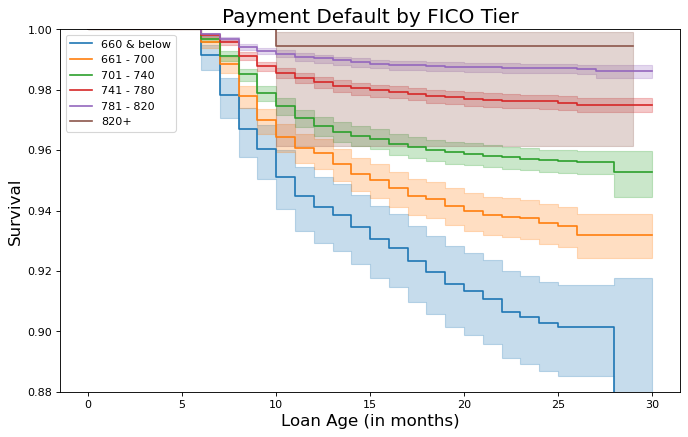

In [59]:
fico_660_below=df_mod['CSCORE_B'] <= 660
fico_661_700=(df_mod['CSCORE_B'] > 660) & (df_mod['CSCORE_B'] <= 700)
fico_701_740=(df_mod['CSCORE_B'] > 700) & (df_mod['CSCORE_B'] <= 740)
fico_741_780=(df_mod['CSCORE_B'] > 741) & (df_mod['CSCORE_B'] <= 780)
fico_781_820=(df_mod['CSCORE_B'] > 780) & (df_mod['CSCORE_B'] <= 820)
fico_821_above=df_mod['CSCORE_B'] > 820

figure(figsize=(10, 6), dpi=80)
ax = plt.subplot(111)
kmf.fit(df_mod[loan_age][fico_660_below], event_observed=df_mod[y][fico_660_below], label='660 & below')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_661_700], event_observed=df_mod[y][fico_661_700], label='661 - 700')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_701_740], event_observed=df_mod[y][fico_701_740], label='701 - 740')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_741_780], event_observed=df_mod[y][fico_741_780], label='741 - 780')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_781_820], event_observed=df_mod[y][fico_781_820], label='781 - 820')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_821_above], event_observed=df_mod[y][fico_821_above], label='820+')
kmf.plot(ax=ax)
plt.title("Payment Default by FICO Tier", fontsize=18)
plt.xlabel("Loan Age (in months)", fontsize=15)
plt.ylim(0.88, 1)
plt.ylabel("Survival", fontsize=15)

* Finding 2: Risk separation by FICO tier is very obvious.

In [60]:
# check property type
df_mod.groupby('PROP')['LOAN_ID'].count()

PROP
CO     7490
CP       13
MH      442
PU    23072
SF    42316
Name: LOAN_ID, dtype: int64

Text(0, 0.5, 'Survival')

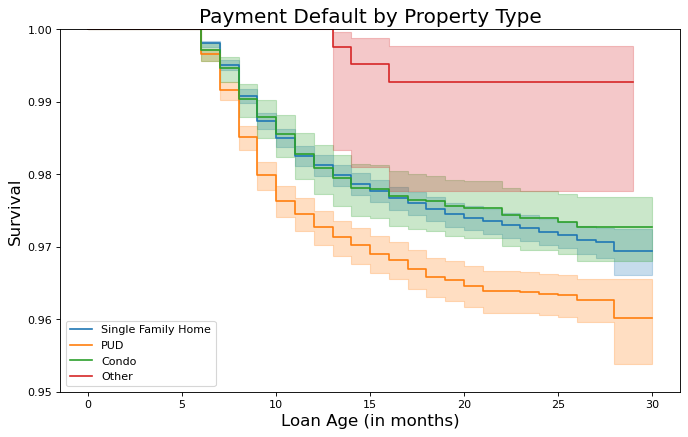

In [61]:
single_family=df_mod['PROP'].str.strip()=='SF'
pud=df_mod['PROP'].str.strip()=='PU'
condo=df_mod['PROP'].str.strip()=='CO'
other=df_mod['PROP'].str.strip().isin(['CP', 'MH'])

figure(figsize=(10, 6), dpi=80)
ax = plt.subplot(111)
kmf.fit(df_mod[loan_age][single_family], event_observed=df_mod[y][single_family], label='Single Family Home')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][pud], event_observed=df_mod[y][pud], label='PUD')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][condo], event_observed=df_mod[y][condo], label='Condo')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][other], event_observed=df_mod[y][other], label='Other')
kmf.plot(ax=ax)
plt.title("Payment Default by Property Type", fontsize=18)
plt.xlabel("Loan Age (in months)", fontsize=15)
plt.ylim(0.95, 1)
plt.ylabel("Survival", fontsize=15)

* Finding 3: PUD has the highest risk.

In [62]:
# check original loan amount
df_mod['ORIG_UPB'].describe()

count     73333.000000
mean     253709.066859
std      124158.219676
min       14000.000000
25%      156000.000000
50%      236000.000000
75%      336000.000000
max      766000.000000
Name: ORIG_UPB, dtype: float64

In [63]:
def upb_tier(x):
    if x < 140000: 
        return '140K & below'
    elif x <= 200000: 
        return '140K - 200K'
    elif x <= 300000:
        return '200K - 300K'
    elif x <= 500000:
        return '300K - 500K'
    else:
        return '500K+'
    
df_mod['upb_band']=df_mod['ORIG_UPB'].apply(upb_tier)

/var/folders/fw/8cyt130j3w99h2qvmlbj79700000gn/T/ipykernel_21569/3406799308.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['upb_band']=df_mod['ORIG_UPB'].apply(upb_tier)


In [64]:
df_mod.groupby('upb_band')['LOAN_ID'].count()

upb_band
140K & below    14479
140K - 200K     14467
200K - 300K     20695
300K - 500K     21197
500K+            2495
Name: LOAN_ID, dtype: int64

Text(0, 0.5, 'Survival')

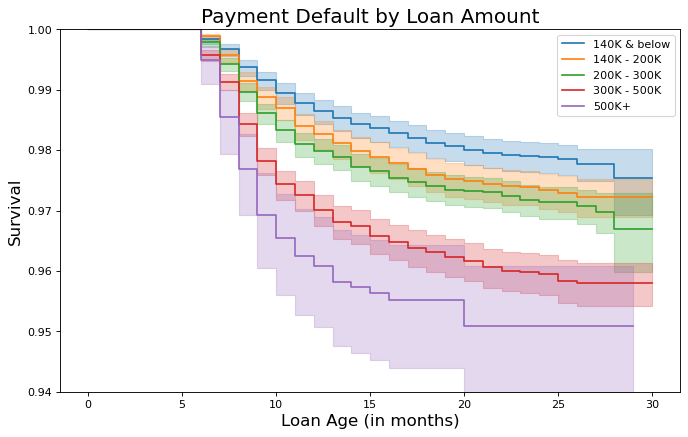

In [65]:
upb_140K_below=df_mod['ORIG_UPB'] <= 140000
upb_140K_200K=(df_mod['ORIG_UPB'] > 140000) & (df_mod['ORIG_UPB'] <= 200000)
upb_200K_300K=(df_mod['ORIG_UPB'] > 200000) & (df_mod['ORIG_UPB'] <= 300000)
upb_300K_500K=(df_mod['ORIG_UPB'] > 300000) & (df_mod['ORIG_UPB'] <= 500000)
upb_500K_above=df_mod['ORIG_UPB'] > 500000

figure(figsize=(10, 6), dpi=80)
ax = plt.subplot(111)
kmf.fit(df_mod[loan_age][upb_140K_below], event_observed=df_mod[y][upb_140K_below], label='140K & below')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][upb_140K_200K], event_observed=df_mod[y][upb_140K_200K], label='140K - 200K')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][upb_200K_300K], event_observed=df_mod[y][upb_200K_300K], label='200K - 300K')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][upb_300K_500K], event_observed=df_mod[y][upb_300K_500K], label='300K - 500K')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][upb_500K_above], event_observed=df_mod[y][upb_500K_above], label='500K+')
kmf.plot(ax=ax)
plt.title("Payment Default by Loan Amount", fontsize=18)
plt.xlabel("Loan Age (in months)", fontsize=15)
plt.ylim(0.94, 1)
plt.ylabel("Survival", fontsize=15)

### In the analysis above, we need to make multple plots to draw individual Kaplan Meier curves for each group. 
### We can simply it by using scikit-survial.

In [153]:
#! pip install scikit-survival

/var/folders/fw/8cyt130j3w99h2qvmlbj79700000gn/T/ipykernel_21569/571682907.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['status']=df_mod[y].map({1: True, 0: False})


Text(0.5, 0, 'Long Age (in months)')

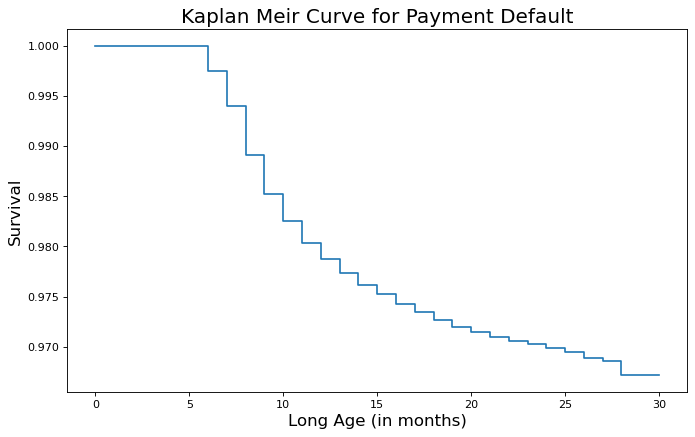

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

# need to convert integers (1, 0) to boolean expression (True, False)
df_mod['status']=df_mod[y].map({1: True, 0: False})

figure(figsize=(10, 6), dpi=80)
time, survival_prob = kaplan_meier_estimator(df_mod["status"], df_mod[loan_age])
plt.step(time, survival_prob, where="post")
plt.title('Kaplan Meir Curve for Payment Default', fontsize=18)
plt.ylabel("Survival", fontsize=15)
plt.xlabel("Long Age (in months)", fontsize=15)

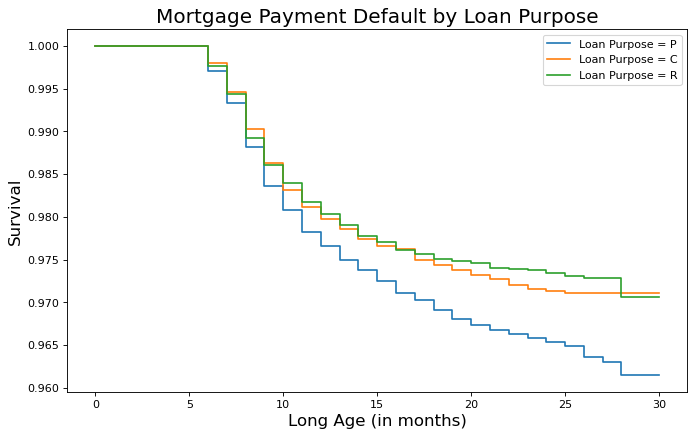

In [71]:
figure(figsize=(10, 6), dpi=80)

for treatment_type in ("P", "C", 'R'):
    mask_treat=df_mod["PURPOSE"] == treatment_type
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])
 
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Loan Purpose = %s" % treatment_type)


plt.title("Mortgage Payment Default by Loan Purpose", fontsize=18)
plt.ylabel("Survival", fontsize=15)
plt.xlabel("Long Age (in months)", fontsize=15)
plt.legend(loc="best")

/var/folders/fw/8cyt130j3w99h2qvmlbj79700000gn/T/ipykernel_21569/434865462.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['property_type']=np.where(df_mod['PROP']=='SF', 'Single Family Home',


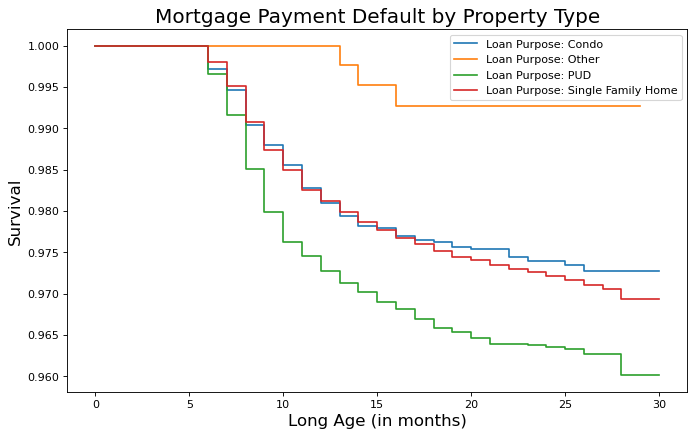

In [72]:
figure(figsize=(10, 6), dpi=80)

df_mod['property_type']=np.where(df_mod['PROP']=='SF', 'Single Family Home', 
                                 np.where(df_mod['PROP']=='PU', 'PUD',
                                          np.where(df_mod['PROP']=='CO', 'Condo', 'Other')))

for treatment_type in (np.unique(df_mod['property_type'])):
    mask_treat=df_mod['property_type']==treatment_type
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Loan Purpose: %s" % treatment_type)

plt.title("Mortgage Payment Default by Property Type", fontsize=18)
plt.ylabel("Survival", fontsize=15)
plt.xlabel("Long Age (in months)", fontsize=15)
plt.legend(loc="best")

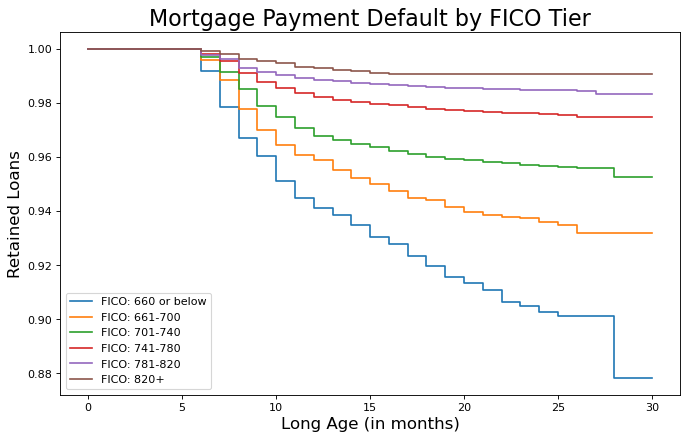

In [73]:
figure(figsize=(10, 6), dpi=80)

for treatment_type in (np.unique(df_mod['fico_band'])):
    mask_treat=df_mod['fico_band']==treatment_type
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="FICO: %s" % treatment_type)

plt.title("Mortgage Payment Default by FICO Tier", fontsize=20)
plt.ylabel("Retained Loans", fontsize=15)
plt.xlabel("Long Age (in months)", fontsize=15)
plt.legend(loc="best")

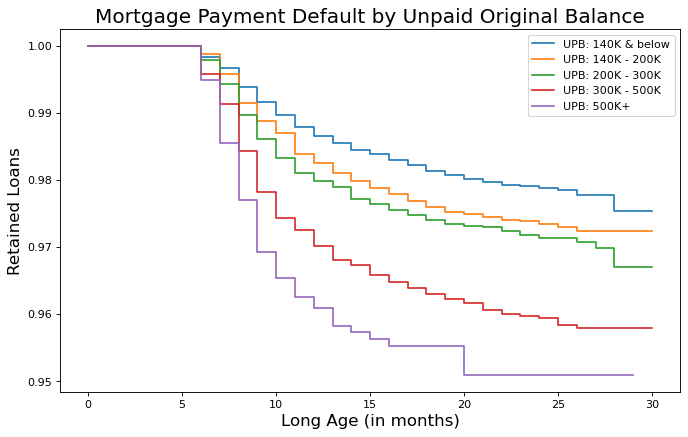

In [74]:
figure(figsize=(10, 6), dpi=80)

for treatment_type in (np.unique(df_mod['upb_band'])):
    mask_treat=df_mod['upb_band']==treatment_type
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="UPB: %s" % treatment_type)

plt.title("Mortgage Payment Default by Unpaid Original Balance", fontsize=18)
plt.ylabel("Retained Loans", fontsize=15)
plt.xlabel("Long Age (in months)", fontsize=15)
plt.legend(loc="best")                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [75]:
df_mod['rate_bin1']=pd.qcut(df_mod['ORIG_RATE'], 5)
df_mod.groupby('rate_bin1')['LOAN_ID'].count()

/var/folders/fw/8cyt130j3w99h2qvmlbj79700000gn/T/ipykernel_21569/2104855318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['rate_bin1']=pd.qcut(df_mod['ORIG_RATE'], 5)


rate_bin1
(2.374, 3.5]      18724
(3.5, 3.75]       20349
(3.75, 3.875]     11132
(3.875, 4.036]     8461
(4.036, 6.5]      14667
Name: LOAN_ID, dtype: int64

In [76]:
df_temp=df_mod.groupby('rate_bin1')['LOAN_ID'].count().reset_index().rename(columns={'LOAN_ID': "loan count"})
df_temp.head()

,rate_bin1,loan count
0,"(2.374, 3.5]",18724
1,"(3.5, 3.75]",20349
2,"(3.75, 3.875]",11132
3,"(3.875, 4.036]",8461
4,"(4.036, 6.5]",14667


<BarContainer object of 5 artists>

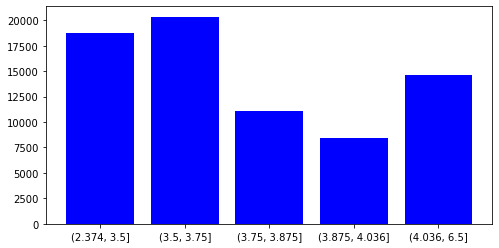

In [77]:
plt.rcParams["figure.figsize"] = (8,4)
plt.bar(df_temp['rate_bin1'].astype(str), df_temp['loan count'], color='blue')

In [78]:
df_mod['rate_bin2']=pd.cut(df_survival['ORIG_RATE'], 5)
df_mod.groupby('rate_bin2')['LOAN_ID'].count()

/var/folders/fw/8cyt130j3w99h2qvmlbj79700000gn/T/ipykernel_21569/4139575113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['rate_bin2']=pd.cut(df_survival['ORIG_RATE'], 5)


rate_bin2
(2.371, 3.2]      5304
(3.2, 4.025]     53360
(4.025, 4.85]    12026
(4.85, 5.675]     2488
(5.675, 6.5]       155
Name: LOAN_ID, dtype: int64

<BarContainer object of 5 artists>

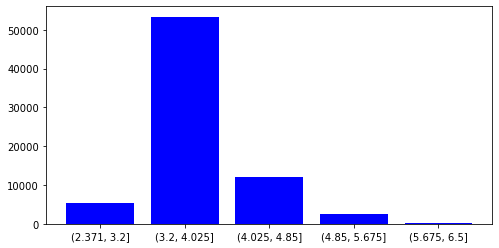

In [79]:
df_temp=df_mod.groupby('rate_bin2')['LOAN_ID'].count().reset_index().rename(columns={'LOAN_ID': "loan count"})

plt.rcParams["figure.figsize"] = (8,4)
plt.bar(df_temp['rate_bin2'].astype(str), df_temp['loan count'], color='blue')

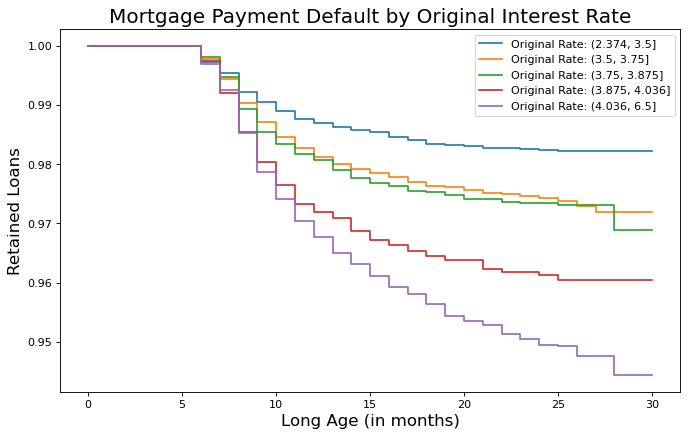

In [80]:
figure(figsize=(10, 6), dpi=80)

for treatment_type in (np.unique(df_mod['rate_bin1'])):
    mask_treat=df_mod['rate_bin1']==treatment_type
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Original Rate: %s" % treatment_type)

plt.title("Mortgage Payment Default by Original Interest Rate", fontsize=18)
plt.ylabel("Retained Loans", fontsize=15)
plt.xlabel("Long Age (in months)", fontsize=15)
plt.legend(loc="best")                                      

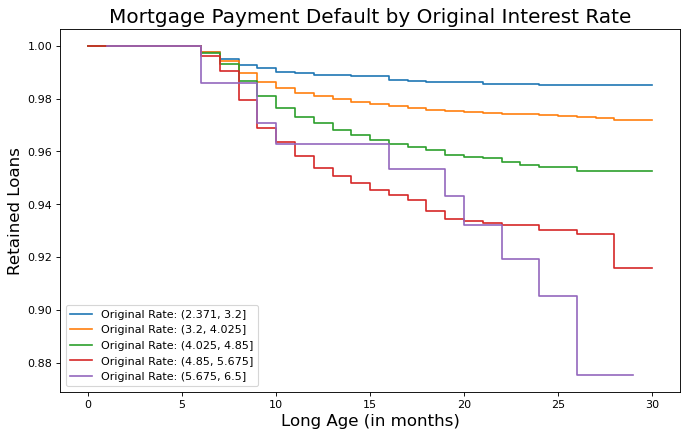

In [81]:
figure(figsize=(10, 6), dpi=80)

for treatment_type in (np.unique(df_mod['rate_bin2'])):
    mask_treat=df_mod['rate_bin2']==treatment_type
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Original Rate: %s" % treatment_type)

plt.title("Mortgage Payment Default by Original Interest Rate", fontsize=18)
plt.ylabel("Retained Loans", fontsize=15)
plt.xlabel("Long Age (in months)", fontsize=15)
plt.legend(loc="best")              

In [82]:
df_mod['DTI'].describe()

count    73333.000000
mean        34.153137
std          9.566134
min          2.000000
25%         27.000000
50%         35.000000
75%         42.000000
max         50.000000
Name: DTI, dtype: float64

In [83]:
def DTI_tier(x):
    if x <= 10: 
        return '10% or below'
    elif x <= 20:
        return '10.01% - 20%'
    elif x <= 30:
        return '20.01% - 30%'
    elif x <= 40: 
        return '30.01% - 40%'
    else:
        return '40%+'

df_mod['DTI_bin']=df_mod['DTI'].apply(DTI_tier)

/var/folders/fw/8cyt130j3w99h2qvmlbj79700000gn/T/ipykernel_21569/3311161520.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['DTI_bin']=df_mod['DTI'].apply(DTI_tier)


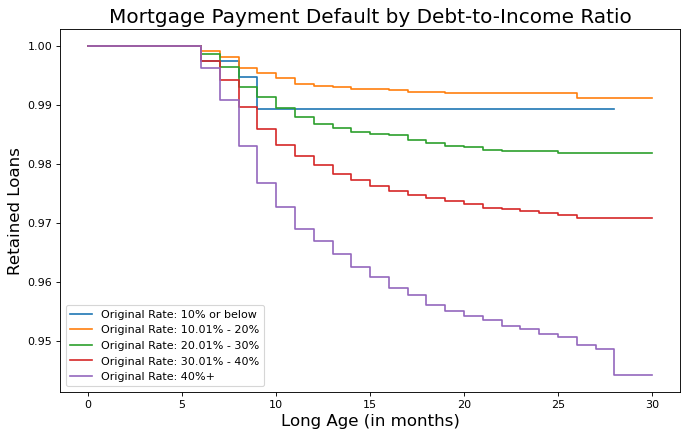

In [84]:
figure(figsize=(10, 6), dpi=80)

for treatment_type in (np.unique(df_mod['DTI_bin'])):
    mask_treat=df_mod['DTI_bin']==treatment_type
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Original Rate: %s" % treatment_type)

plt.title("Mortgage Payment Default by Debt-to-Income Ratio", fontsize=18)
plt.ylabel("Retained Loans", fontsize=15)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
plt.xlabel("Long Age (in months)", fontsize=15)
plt.legend(loc="best")                   

#### If the sample is big enough, we can make more granular segments such as the following: 
* interest rate + loan amount
* interest rate + loan amount + DTI
* etc.

In [85]:
df_mod['DTI & FICO']='DTI:'+df_mod['DTI_bin'].astype(str)+' / FICO:'+df_mod['fico_band'].astype(str)

df_mod.groupby('DTI & FICO')['LOAN_ID'].count()

/var/folders/fw/8cyt130j3w99h2qvmlbj79700000gn/T/ipykernel_21569/2516869266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['DTI & FICO']='DTI:'+df_mod['DTI_bin'].astype(str)+' / FICO:'+df_mod['fico_band'].astype(str)


DTI & FICO
DTI:10% or below / FICO:660 or below       6
DTI:10% or below / FICO:661-700           13
DTI:10% or below / FICO:701-740           39
DTI:10% or below / FICO:741-780          103
DTI:10% or below / FICO:781-820          115
DTI:10% or below / FICO:820+             127
DTI:10.01% - 20% / FICO:660 or below      85
DTI:10.01% - 20% / FICO:661-700          261
DTI:10.01% - 20% / FICO:701-740          726
DTI:10.01% - 20% / FICO:741-780         1709
DTI:10.01% - 20% / FICO:781-820         2017
DTI:10.01% - 20% / FICO:820+            1685
DTI:20.01% - 30% / FICO:660 or below     444
DTI:20.01% - 30% / FICO:661-700         1255
DTI:20.01% - 30% / FICO:701-740         2815
DTI:20.01% - 30% / FICO:741-780         6077
DTI:20.01% - 30% / FICO:781-820         5052
DTI:20.01% - 30% / FICO:820+            3448
DTI:30.01% - 40% / FICO:660 or below     752
DTI:30.01% - 40% / FICO:661-700         2518
DTI:30.01% - 40% / FICO:701-740         5114
DTI:30.01% - 40% / FICO:741-780         8291

/var/folders/fw/8cyt130j3w99h2qvmlbj79700000gn/T/ipykernel_21569/4039975441.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['status']=df_mod[y].map({1: True, 0: False})


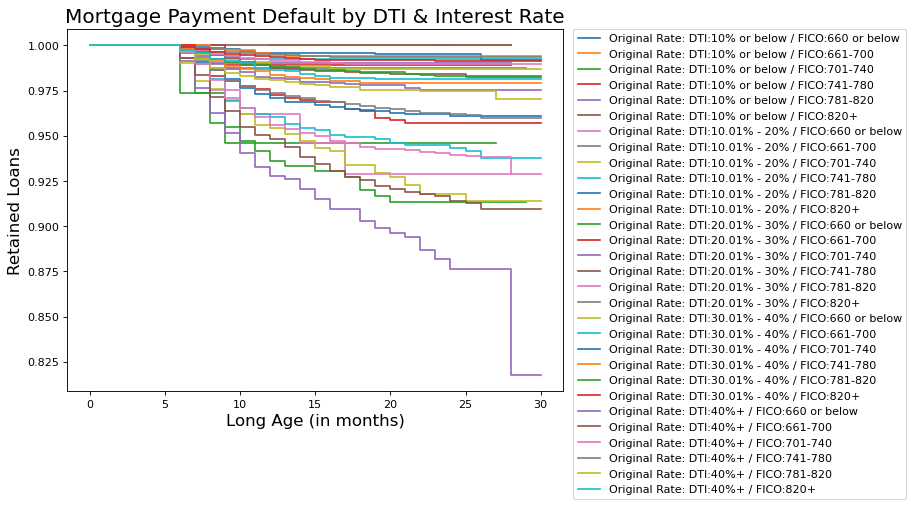

In [86]:
y='bad'
load_age='loan_age_bad'
df_mod['status']=df_mod[y].map({1: True, 0: False})

figure(figsize=(8, 6), dpi=80)

for treatment_type in (np.unique(df_mod['DTI & FICO'])):
    mask_treat=df_mod['DTI & FICO']==treatment_type
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Original Rate: %s" % treatment_type)

plt.title("Mortgage Payment Default by DTI & Interest Rate", fontsize=18)
plt.ylabel("Retained Loans", fontsize=15)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
plt.xlabel("Long Age (in months)", fontsize=15)
#plt.legend(bbox_to_anchor=(1.02, 0.1), loc='upper left', borderaxespad=0)        
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)     

<AxesSubplot:xlabel='timeline'>

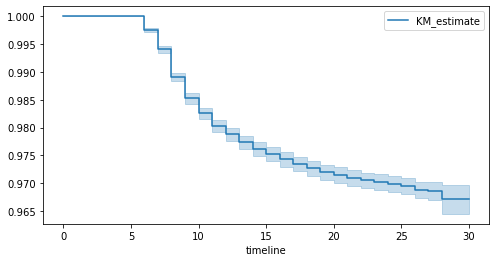

In [87]:
# get the Kaplan Meier estimate 

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(df_mod['loan_age_bad'], event_observed=df_mod['bad']) # or, more succinctly, kmf.fit(T, E)

kmf.survival_function_
kmf.cumulative_density_
kmf.plot_survival_function()

<AxesSubplot:xlabel='timeline'>

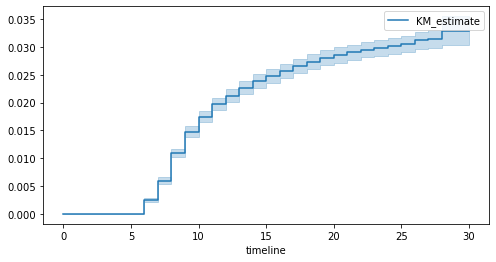

In [88]:
kmf.plot_cumulative_density()

In [89]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
1.0,1.000000
2.0,1.000000
3.0,1.000000
4.0,1.000000
5.0,1.000000
6.0,0.997522
7.0,0.994047
8.0,0.989103


In [90]:
group_list=np.unique(df_mod['DTI & FICO'])

kmf_curve_temp=[]
for item in np.unique(df_mod['DTI & FICO']):
    df_temp=df_mod[df_mod['DTI & FICO']==item]
    
    # We must reset kmf so that it will not inherit computation from above to cause confusion
    kmf = KaplanMeierFitter()
    df_mod_estimate=kmf.fit(df_temp['loan_age_bad'], 
                                 event_observed=df_temp['bad'])
    kmf_curve=kmf.survival_function_.reset_index().rename(columns={'timeline': 'loan_age'})

    # add shell of loan age in case soe timeline might be missing for KM curve
    loan_age_shell=np.arange(0, max(df_temp['loan_age_bad'].astype(int))+1, 1)
    loan_age_shell=pd.DataFrame(loan_age_shell).rename(columns={0: 'loan_age'})
    kmf_curve=pd.merge(kmf_curve, loan_age_shell, on='loan_age', how='outer')
    kmf_curve=kmf_curve.sort_values(by='loan_age').reset_index().drop('index', axis=1)
    # for those months (loan age) with missing KM_estimate, it means the survival rate the same as the previous month.
    # Therefore, we fill with the value backwards.
    kmf_curve['KM_estimate']=kmf_curve['KM_estimate'].bfill()
    kmf_curve['group_name']=item
    kmf_curve_temp.append(kmf_curve)
    kmf_curve_bad=pd.concat(kmf_curve_temp, axis=0).rename(columns={'KM_estimate': 'KM_est_surviving_bad'})

#### If we have a portfolio of loans, we can do the following: 
* 1) create the same group_name by using DTI and original interest rate.
* 2) Merge with the test file by the group_name, and you get the estimated survival rate by loan age. 

# Part 3: Kaplan Meier Curve for Voluntary Prepayment
* We will use scikit-survival only here.

Text(0, 0.5, 'Survival')

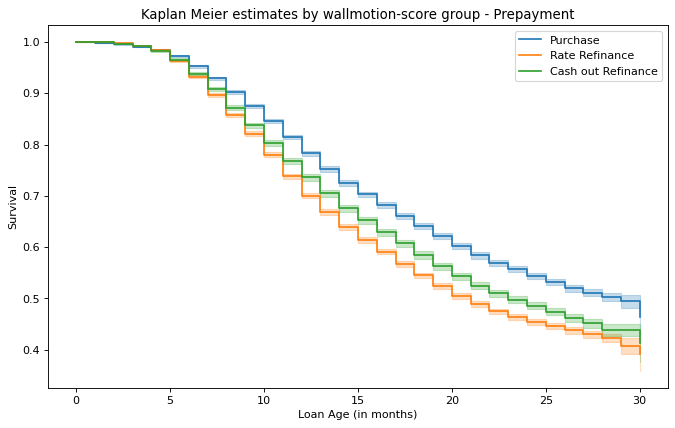

In [91]:
loan_age='loan_age_prepaid'
y='prepaid'

figure(figsize=(10, 6), dpi=80)
ax = plt.subplot(111)
purchase=df_mod['PURPOSE'].str.strip()=='P'
rate_refi=df_mod['PURPOSE'].str.strip()=='R'
cashout_refi=df_mod['PURPOSE'].str.strip()=='C'

kmf.fit(df_mod[loan_age][purchase], event_observed=df_mod[y][purchase], label = 'Purchase')
kmf.plot(ax = ax)
kmf.fit(df_mod[loan_age][rate_refi], event_observed=df_mod[y][rate_refi], label = 'Rate Refinance')
kmf.plot(ax = ax)
kmf.fit(df_mod[loan_age][cashout_refi], event_observed=df_mod[y][cashout_refi], label = 'Cash out Refinance')
kmf.plot(ax = ax)
plt.title("Kaplan Meier estimates by wallmotion-score group - Prepayment")
plt.xlabel("Loan Age (in months)")
plt.ylabel("Survival")

Text(0, 0.5, 'Survival')

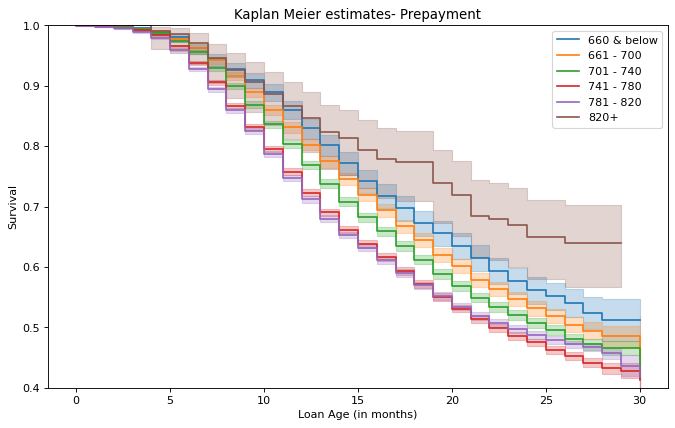

In [92]:
fico_660_below=df_mod['CSCORE_B'] <= 660
fico_661_700=(df_mod['CSCORE_B'] > 660) & (df_mod['CSCORE_B'] <= 700)
fico_701_740=(df_mod['CSCORE_B'] > 700) & (df_mod['CSCORE_B'] <= 740)
fico_741_780=(df_mod['CSCORE_B'] > 741) & (df_mod['CSCORE_B'] <= 780)
fico_781_820=(df_mod['CSCORE_B'] > 780) & (df_mod['CSCORE_B'] <= 820)
fico_821_above=df_mod['CSCORE_B'] > 820

figure(figsize=(10, 6), dpi=80)                                                                                    
ax = plt.subplot(111)
kmf.fit(df_mod[loan_age][fico_660_below], event_observed=df_mod[y][fico_660_below], label='660 & below')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_661_700], event_observed=df_mod[y][fico_661_700], label='661 - 700')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_701_740], event_observed=df_mod[y][fico_701_740], label='701 - 740')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_741_780], event_observed=df_mod[y][fico_741_780], label='741 - 780')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_781_820], event_observed=df_mod[y][fico_781_820], label='781 - 820')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_821_above], event_observed=df_mod[y][fico_821_above], label='820+')
kmf.plot(ax=ax)
plt.title("Kaplan Meier estimates- Prepayment")
plt.xlabel("Loan Age (in months)")
plt.ylim(0.40, 1)                                        
plt.ylabel("Survival")

Text(0, 0.5, 'Survival')

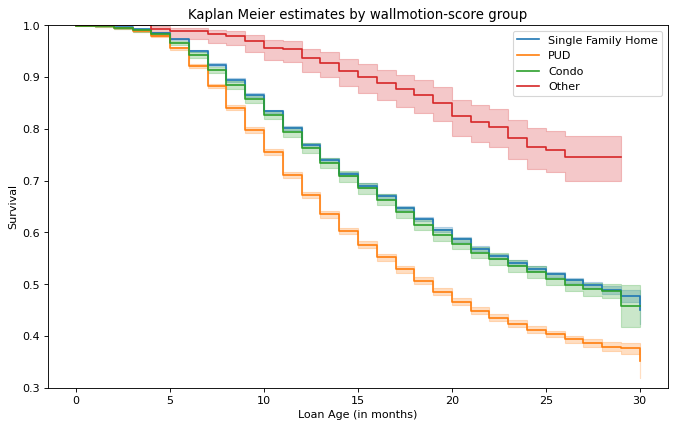

In [93]:
single_family=df_mod['PROP'].str.strip()=='SF'
pud=df_mod['PROP'].str.strip()=='PU'
condo=df_mod['PROP'].str.strip()=='CO'
other=df_mod['PROP'].str.strip().isin(['CP', 'MH'])

figure(figsize=(10, 6), dpi=80)
ax = plt.subplot(111)
kmf.fit(df_mod[loan_age][single_family], event_observed=df_mod[y][single_family], label='Single Family Home')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][pud], event_observed=df_mod[y][pud], label='PUD')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][condo], event_observed=df_mod[y][condo], label='Condo')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][other], event_observed=df_mod[y][other], label='Other')
kmf.plot(ax=ax)
plt.title("Kaplan Meier estimates by wallmotion-score group")
plt.xlabel("Loan Age (in months)")
plt.ylim(0.3, 1)
plt.ylabel("Survival")

In [94]:
df_mod.groupby('PROP')['ORIG_RATE'].describe()

,count,mean,std,min,25%,50%,75%,max
PROP,,,,,,,,
CO,7490.0,3.836956,0.446798,2.375,3.62500,3.875,4.000,6.125
CP,13.0,4.240385,0.390184,3.750,4.00000,4.125,4.375,5.000
MH,442.0,4.136369,0.516542,2.750,3.75000,4.125,4.375,5.875
PU,23072.0,3.749534,0.409478,2.375,3.50000,3.750,3.990,6.125
SF,42316.0,3.831809,0.471175,2.375,3.55975,3.750,4.000,6.500


In [95]:
df_mod.groupby('PROP')['ORIG_UPB'].describe()

,count,mean,std,min,25%,50%,75%,max
PROP,,,,,,,,
CO,7490.0,224699.332443,104808.576055,18000.0,145000.0,208000.0,286000.0,727000.0
CP,13.0,62615.384615,45781.252461,31000.0,39000.0,42000.0,63000.0,200000.0
MH,442.0,131581.447964,75230.161846,32000.0,83000.0,109000.0,162750.0,510000.0
PU,23072.0,314725.338072,116992.966403,19000.0,228000.0,305000.0,395000.0,766000.0
SF,42316.0,226910.223083,119097.695363,14000.0,135000.0,203000.0,298000.0,766000.0


Text(0, 0.5, 'Survival')

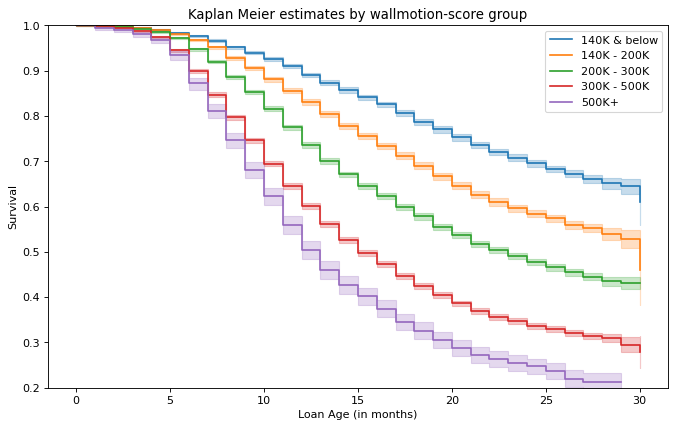

In [96]:
upb_140K_200K=(df_mod['ORIG_UPB'] > 140000) & (df_mod['ORIG_UPB'] <= 200000)
upb_200K_300K=(df_mod['ORIG_UPB'] > 200000) & (df_mod['ORIG_UPB'] <= 300000)
upb_300K_500K=(df_mod['ORIG_UPB'] > 300000) & (df_mod['ORIG_UPB'] <= 500000)
upb_500K_above=df_mod['ORIG_UPB'] > 500000

figure(figsize=(10, 6), dpi=80)
ax = plt.subplot(111)
kmf.fit(df_mod[loan_age][upb_140K_below], event_observed=df_mod[y][upb_140K_below], label='140K & below')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][upb_140K_200K], event_observed=df_mod[y][upb_140K_200K], label='140K - 200K')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][upb_200K_300K], event_observed=df_mod[y][upb_200K_300K], label='200K - 300K')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][upb_300K_500K], event_observed=df_mod[y][upb_300K_500K], label='300K - 500K')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][upb_500K_above], event_observed=df_mod[y][upb_500K_above], label='500K+')
kmf.plot(ax=ax)                                                                                                        
plt.title("Kaplan Meier estimates by wallmotion-score group")
plt.xlabel("Loan Age (in months)")
plt.ylim(0.2, 1)
plt.ylabel("Survival")

/var/folders/fw/8cyt130j3w99h2qvmlbj79700000gn/T/ipykernel_21569/1878691586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[loan_age]=np.where(df_mod[loan_age] <= 0, 1, df_mod[loan_age])


<AxesSubplot:>

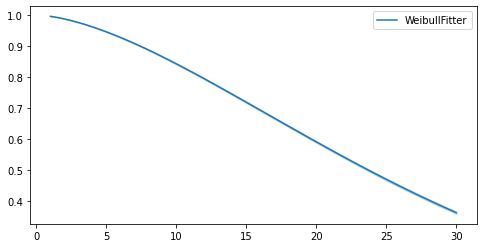

In [97]:
from lifelines import WeibullFitter

df_mod[loan_age]=np.where(df_mod[loan_age] <= 0, 1, df_mod[loan_age])
wbf = WeibullFitter().fit(df_mod[loan_age], df_mod['prepaid'], label='WeibullFitter')
wbf.plot_survival_function()

/var/folders/fw/8cyt130j3w99h2qvmlbj79700000gn/T/ipykernel_21569/165608689.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['status']=df_mod[y].map({1: True, 0: False})


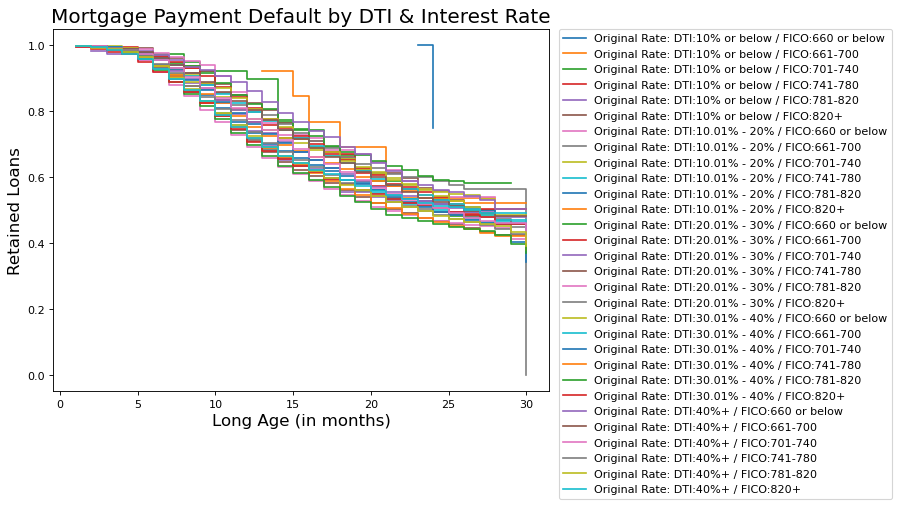

In [98]:
# need to convert integers (1, 0) to boolean expression (True, False)
df_mod['status']=df_mod[y].map({1: True, 0: False})

figure(figsize=(8, 6), dpi=80)

for treatment_type in (np.unique(df_mod['DTI & FICO'])):
    mask_treat=df_mod['DTI & FICO']==treatment_type
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Original Rate: %s" % treatment_type)

plt.title("Mortgage Payment Default by DTI & Interest Rate", fontsize=18)
plt.ylabel("Retained Loans", fontsize=15)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
plt.xlabel("Long Age (in months)", fontsize=15)
#plt.legend(bbox_to_anchor=(1.02, 0.1), loc='upper left', borderaxespad=0)        
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)     

In [99]:
group_list=np.unique(df_mod['DTI & FICO'])

kmf_curve_temp=[]
for item in np.unique(df_mod['DTI & FICO']):
    df_temp=df_mod[df_mod['DTI & FICO']==item]
    
    # We must reset kmf so that it will not inherit computation from above to cause confusion
    kmf = KaplanMeierFitter()
    df_mod_estimate=kmf.fit(df_temp['loan_age_prepaid'], 
                                 event_observed=df_temp['prepaid'])
    kmf_curve=kmf.survival_function_.reset_index().rename(columns={'timeline': 'loan_age'})

    # add shell of loan age in case soe timeline might be missing for KM curve
    loan_age_shell=np.arange(0, max(df_temp['loan_age_prepaid'].astype(int))+1, 1)
    loan_age_shell=pd.DataFrame(loan_age_shell).rename(columns={0: 'loan_age'})
    kmf_curve=pd.merge(kmf_curve, loan_age_shell, on='loan_age', how='outer')
    kmf_curve=kmf_curve.sort_values(by='loan_age').reset_index().drop('index', axis=1)
    # for those months (loan age) with missing KM_estimate, it means the survival rate the same as the previous month.
    # Therefore, we fill with the value backwards.
    kmf_curve['KM_estimate']=kmf_curve['KM_estimate'].bfill()
    kmf_curve['group_name']=item
    kmf_curve_temp.append(kmf_curve)
    kmf_curve_prepay=pd.concat(kmf_curve_temp, axis=0).rename(columns={'KM_estimate': 'KM_est_surviving_prepay'})

In [100]:
kmf_curve_prepay.head(50)

,loan_age,KM_est_surviving_prepay,group_name
0,0.0,1.000000,DTI:10% or below / FICO:660 or below
1,1.0,1.000000,DTI:10% or below / FICO:660 or below
2,2.0,1.000000,DTI:10% or below / FICO:660 or below
3,3.0,1.000000,DTI:10% or below / FICO:660 or below
4,4.0,1.000000,DTI:10% or below / FICO:660 or below
5,5.0,1.000000,DTI:10% or below / FICO:660 or below
6,6.0,1.000000,DTI:10% or below / FICO:660 or below
7,7.0,1.000000,DTI:10% or below / FICO:660 or below
8,8.0,1.000000,DTI:10% or below / FICO:660 or below
9,9.0,1.000000,DTI:10% or below / FICO:660 or below


# Part 4: Combine Kaplan Meier estimates for payment default and prepayment

In [101]:
survival_estimate=pd.merge(kmf_curve_bad, kmf_curve_prepay, on=['group_name', 'loan_age'], how='inner')
survival_estimate=survival_estimate[['group_name', 'loan_age', 'KM_est_surviving_bad', 'KM_est_surviving_prepay']]
survival_estimate['est_cumu_bad']=1-survival_estimate['KM_est_surviving_bad']
survival_estimate['est_cumu_prepay']=1-survival_estimate['KM_est_surviving_prepay']

In [102]:
survival_estimate.head(50)

,group_name,loan_age,KM_est_surviving_bad,KM_est_surviving_prepay,est_cumu_bad,est_cumu_prepay
0,DTI:10% or below / FICO:660 or below,0.0,1.0,1.000000,0.0,0.000000
1,DTI:10% or below / FICO:660 or below,1.0,1.0,1.000000,0.0,0.000000
2,DTI:10% or below / FICO:660 or below,2.0,1.0,1.000000,0.0,0.000000
3,DTI:10% or below / FICO:660 or below,3.0,1.0,1.000000,0.0,0.000000
4,DTI:10% or below / FICO:660 or below,4.0,1.0,1.000000,0.0,0.000000
5,DTI:10% or below / FICO:660 or below,5.0,1.0,1.000000,0.0,0.000000
6,DTI:10% or below / FICO:660 or below,6.0,1.0,1.000000,0.0,0.000000
7,DTI:10% or below / FICO:660 or below,7.0,1.0,1.000000,0.0,0.000000
8,DTI:10% or below / FICO:660 or below,8.0,1.0,1.000000,0.0,0.000000
9,DTI:10% or below / FICO:660 or below,9.0,1.0,1.000000,0.0,0.000000


# Part 4: Validate on the validation model

In [103]:
def fico_tier(x):
    if x <= 660:
        return '660 or below'
    elif x <= 700:
        return '661-700'
    elif x <= 740:
        return '701-740'
    elif x <=780:
        return '741-780'
    elif x <=800:
        return '781-820'
    else:
        return '820+'
    
df_val['fico_band']=df_val['CSCORE_B'].apply(fico_tier)

def DTI_tier(x):
    if x <= 10: 
        return '10% or below'
    elif x <= 20:
        return '10.01%-20%'
    elif x <= 30:
        return '20.01%-30%'
    elif x <= 40: 
        return '30.01%-40%'
    else:
        return '40%+'

df_val['DTI_bin']=df_val['DTI'].apply(DTI_tier)

/var/folders/fw/8cyt130j3w99h2qvmlbj79700000gn/T/ipykernel_21569/212045139.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['fico_band']=df_val['CSCORE_B'].apply(fico_tier)
/var/folders/fw/8cyt130j3w99h2qvmlbj79700000gn/T/ipykernel_21569/212045139.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['DTI_bin']=df_val['DTI'].apply(DTI_tier)


In [104]:
df_val['DTI & FICO']='DTI:'+df_val['DTI_bin'].astype(str)+' / FICO:'+df_val['fico_band'].astype(str)

/var/folders/fw/8cyt130j3w99h2qvmlbj79700000gn/T/ipykernel_21569/3367400119.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['DTI & FICO']='DTI:'+df_val['DTI_bin'].astype(str)+' / FICO:'+df_val['fico_band'].astype(str)


In [105]:
group_list=np.unique(df_val['DTI & FICO'])

kmf_curve_temp=[]
for item in np.unique(df_val['DTI & FICO']):
    df_temp=df_val[df_val['DTI & FICO']==item]
    
    # We must reset kmf so that it will not inherit computation from above to cause confusion
    kmf = KaplanMeierFitter()
    df_val_estimate=kmf.fit(df_temp['loan_age_prepaid'], event_observed=df_temp['prepaid'])
    kmf_curve=kmf.survival_function_.reset_index().rename(columns={'timeline': 'loan_age'})
    
    # add shell of loan age in case soe timeline might be missing for KM curve
    loan_age_shell=np.arange(0, max(df_temp['loan_age_prepaid'].astype(int))+1, 1)
    loan_age_shell=pd.DataFrame(loan_age_shell).rename(columns={0: 'loan_age'})
    kmf_curve=pd.merge(kmf_curve, loan_age_shell, on='loan_age', how='outer')
    kmf_curve=kmf_curve.sort_values(by='loan_age').reset_index().drop('index', axis=1)
    # for those months (loan age) with missing KM_estimate, it means the survival rate the same as the previous month.
    # Therefore, we fill with the value backwards.
    kmf_curve['KM_estimate']=kmf_curve['KM_estimate'].bfill()
    kmf_curve['group_name']=item
    kmf_curve_temp.append(kmf_curve)
kmf_curve_prepay_val=pd.concat(kmf_curve_temp, axis=0).rename(columns={'KM_estimate': 'KM_act_surviving_prepay'})
kmf_curve_prepay_val.head()

,loan_age,KM_act_surviving_prepay,group_name
0,0.0,1.000000,DTI:10% or below / FICO:660 or below
1,1.0,0.333333,DTI:10% or below / FICO:660 or below
2,2.0,0.333333,DTI:10% or below / FICO:660 or below
3,3.0,0.333333,DTI:10% or below / FICO:660 or below
4,4.0,0.333333,DTI:10% or below / FICO:660 or below


In [106]:
kmf_curve_prepay_val['group_name'].unique()

array(['DTI:10% or below / FICO:660 or below',
       'DTI:10% or below / FICO:661-700',
       'DTI:10% or below / FICO:701-740',
       'DTI:10% or below / FICO:741-780',
       'DTI:10% or below / FICO:781-820', 'DTI:10% or below / FICO:820+',
       'DTI:10.01%-20% / FICO:660 or below',
       'DTI:10.01%-20% / FICO:661-700', 'DTI:10.01%-20% / FICO:701-740',
       'DTI:10.01%-20% / FICO:741-780', 'DTI:10.01%-20% / FICO:781-820',
       'DTI:10.01%-20% / FICO:820+', 'DTI:20.01%-30% / FICO:660 or below',
       'DTI:20.01%-30% / FICO:661-700', 'DTI:20.01%-30% / FICO:701-740',
       'DTI:20.01%-30% / FICO:741-780', 'DTI:20.01%-30% / FICO:781-820',
       'DTI:20.01%-30% / FICO:820+', 'DTI:30.01%-40% / FICO:660 or below',
       'DTI:30.01%-40% / FICO:661-700', 'DTI:30.01%-40% / FICO:701-740',
       'DTI:30.01%-40% / FICO:741-780', 'DTI:30.01%-40% / FICO:781-820',
       'DTI:30.01%-40% / FICO:820+', 'DTI:40%+ / FICO:660 or below',
       'DTI:40%+ / FICO:661-700', 'DTI:40%+ / FICO:

In [107]:
group_list=np.unique(df_val['DTI & FICO'])

kmf_curve_temp=[]
for item in np.unique(df_val['DTI & FICO']):
    df_temp=df_val[df_val['DTI & FICO']==item]
    
    # We must reset kmf so that it will not inherit computation from above to cause confusion
    kmf = KaplanMeierFitter()
    df_val_estimate=kmf.fit(df_temp['loan_age_bad'], event_observed=df_temp['bad'])
    kmf_curve=kmf.survival_function_.reset_index().rename(columns={'timeline': 'loan_age'})

    # add shell of loan age in case soe timeline might be missing for KM curve
    loan_age_shell=np.arange(0, max(df_temp['loan_age_bad'].astype(int))+1, 1)
    loan_age_shell=pd.DataFrame(loan_age_shell).rename(columns={0: 'loan_age'})
    kmf_curve=pd.merge(kmf_curve, loan_age_shell, on='loan_age', how='outer')
    kmf_curve=kmf_curve.sort_values(by='loan_age').reset_index().drop('index', axis=1)
    # for those months (loan age) with missing KM_estimate, it means the survival rate the same as the previous month.
    # Therefore, we fill with the value backwards.
    kmf_curve['KM_estimate']=kmf_curve['KM_estimate'].bfill()
    kmf_curve['group_name']=item
    kmf_curve_temp.append(kmf_curve)
kmf_curve_bad_val=pd.concat(kmf_curve_temp, axis=0).rename(columns={'KM_estimate': 'KM_act_surviving_bad'})
kmf_curve_bad_val.head()

,loan_age,KM_act_surviving_bad,group_name
0,0.0,1.0,DTI:10% or below / FICO:660 or below
1,1.0,1.0,DTI:10% or below / FICO:660 or below
2,2.0,1.0,DTI:10% or below / FICO:660 or below
3,3.0,1.0,DTI:10% or below / FICO:660 or below
4,4.0,1.0,DTI:10% or below / FICO:660 or below


In [108]:
survival_actual=pd.merge(kmf_curve_bad_val, kmf_curve_prepay_val, on=['group_name', 'loan_age'], how='inner')
survival_actual=survival_actual[['group_name', 'loan_age', 'KM_act_surviving_bad', 'KM_act_surviving_prepay']]
survival_actual['act_cumu_bad']=1-survival_actual['KM_act_surviving_bad']
survival_actual['act_cumu_prepay']=1-survival_actual['KM_act_surviving_prepay']

In [109]:
merge_two=pd.merge(survival_estimate, survival_actual, on=['loan_age', 'group_name'], how='inner')

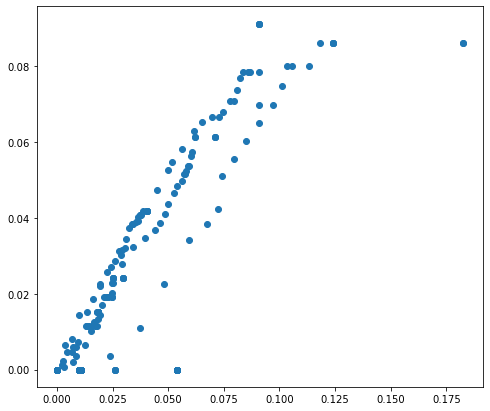

In [110]:
plt.rcParams["figure.figsize"] = (8,7)
plt.scatter(merge_two['est_cumu_bad'], merge_two['act_cumu_bad'])

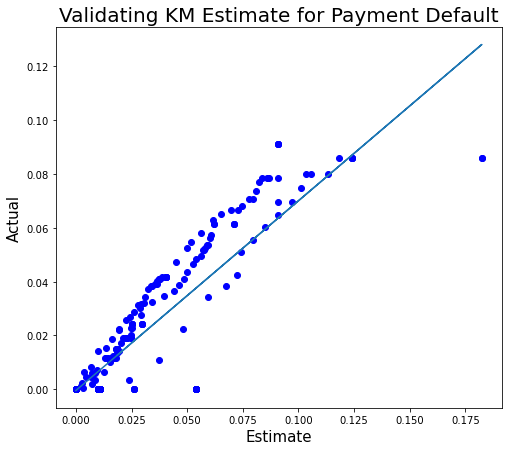

                            OLS Regression Results                            
Dep. Variable:           act_cumu_bad   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     1190.
Date:                Mon, 22 Jan 2024   Prob (F-statistic):          2.36e-114
Time:                        19:10:12   Log-Likelihood:                 1049.6
No. Observations:                 350   AIC:                            -2095.
Df Residuals:                     348   BIC:                            -2087.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0004      0.001     -0.524   

In [111]:
x=merge_two['est_cumu_bad']
y= merge_two['act_cumu_bad']

plt.scatter(x, y, color='b')
plt.xlabel('Estimate', fontsize=15)
plt.ylabel('Actual', fontsize=15)
plt.title("Validating KM Estimate for Payment Default", fontsize=20)

# add a regression line to show the relationship
m, b=np.polyfit(x, y, 1)
plt.plot(x, m*x+b)
plt.show()


# Regression analysis
import statsmodels.api as sm

# add constant to predictor variables
x = sm.add_constant(x)

# fit linear regression model
model = sm.OLS(y, x).fit()

# view model summary
print(model.summary())

##### 

In [112]:
df_mod.groupby('DTI & FICO')['LOAN_ID'].count()

DTI & FICO
DTI:10% or below / FICO:660 or below       6
DTI:10% or below / FICO:661-700           13
DTI:10% or below / FICO:701-740           39
DTI:10% or below / FICO:741-780          103
DTI:10% or below / FICO:781-820          115
DTI:10% or below / FICO:820+             127
DTI:10.01% - 20% / FICO:660 or below      85
DTI:10.01% - 20% / FICO:661-700          261
DTI:10.01% - 20% / FICO:701-740          726
DTI:10.01% - 20% / FICO:741-780         1709
DTI:10.01% - 20% / FICO:781-820         2017
DTI:10.01% - 20% / FICO:820+            1685
DTI:20.01% - 30% / FICO:660 or below     444
DTI:20.01% - 30% / FICO:661-700         1255
DTI:20.01% - 30% / FICO:701-740         2815
DTI:20.01% - 30% / FICO:741-780         6077
DTI:20.01% - 30% / FICO:781-820         5052
DTI:20.01% - 30% / FICO:820+            3448
DTI:30.01% - 40% / FICO:660 or below     752
DTI:30.01% - 40% / FICO:661-700         2518
DTI:30.01% - 40% / FICO:701-740         5114
DTI:30.01% - 40% / FICO:741-780         8291

In [113]:
df_count=df_mod.groupby('DTI & FICO')['LOAN_ID'].count().reset_index().rename(columns={'LOAN_ID': 'loan_cnt', 
                                                                                       'DTI & FICO': 'group_name'})

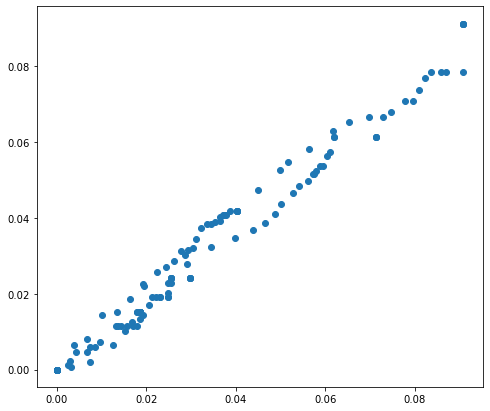

In [114]:
merge_two2=pd.merge(df_count, merge_two, on='group_name', how='inner')
for_graph=merge_two[merge_two2['loan_cnt'] > 1000]

plt.rcParams["figure.figsize"] = (8,7)
plt.scatter(for_graph['est_cumu_bad'], for_graph['act_cumu_bad'])

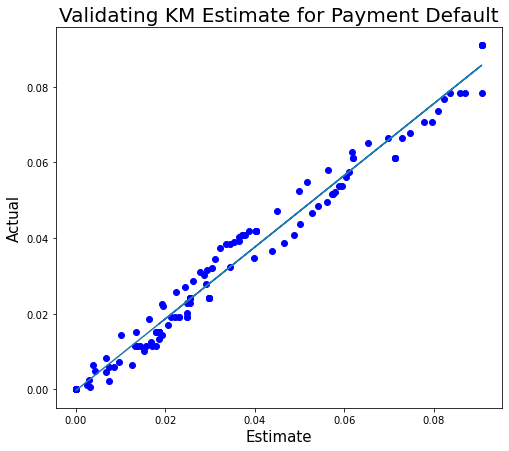

                            OLS Regression Results                            
Dep. Variable:           act_cumu_bad   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     8332.
Date:                Mon, 22 Jan 2024   Prob (F-statistic):          2.51e-135
Time:                        19:10:13   Log-Likelihood:                 664.60
No. Observations:                 155   AIC:                            -1325.
Df Residuals:                     153   BIC:                            -1319.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0003      0.000     -0.820   

In [115]:
x=for_graph['est_cumu_bad']
y=for_graph['act_cumu_bad']

plt.scatter(x, y, color='b')
plt.xlabel('Estimate', fontsize=15)
plt.ylabel('Actual', fontsize=15)
plt.title("Validating KM Estimate for Payment Default", fontsize=20)

# add a regression line to show the relationship
m, b=np.polyfit(x, y, 1)
plt.plot(x, m*x+b)
plt.show()


# Regression analysis
import statsmodels.api as sm

# add constant to predictor variables
x = sm.add_constant(x)

# fit linear regression model
model = sm.OLS(y, x).fit()

# view model summary
print(model.summary())

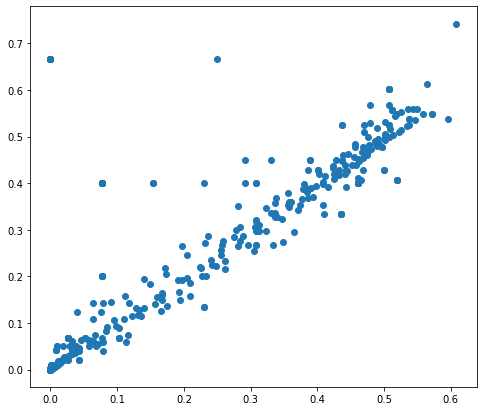

In [116]:
plt.rcParams["figure.figsize"] = (8,7)
plt.scatter(merge_two['est_cumu_prepay'], merge_two['act_cumu_prepay'])

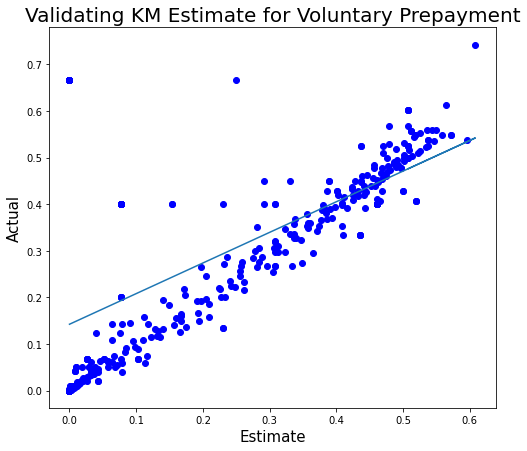

                            OLS Regression Results                            
Dep. Variable:        act_cumu_prepay   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     218.1
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           1.16e-38
Time:                        19:10:14   Log-Likelihood:                 138.46
No. Observations:                 350   AIC:                            -272.9
Df Residuals:                     348   BIC:                            -265.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1422      0.014     

In [117]:
x=merge_two['est_cumu_prepay']
y= merge_two['act_cumu_prepay']

plt.scatter(x, y, color='b')
plt.xlabel('Estimate', fontsize=15)
plt.ylabel('Actual', fontsize=15)
plt.title("Validating KM Estimate for Voluntary Prepayment", fontsize=20)

# add a regression line to show the relationship
m, b=np.polyfit(x, y, 1)
plt.plot(x, m*x+b)
plt.show()


# Regression analysis
import statsmodels.api as sm

# add constant to predictor variables
x = sm.add_constant(x)

# fit linear regression model
model = sm.OLS(y, x).fit()

# view model summary
print(model.summary())

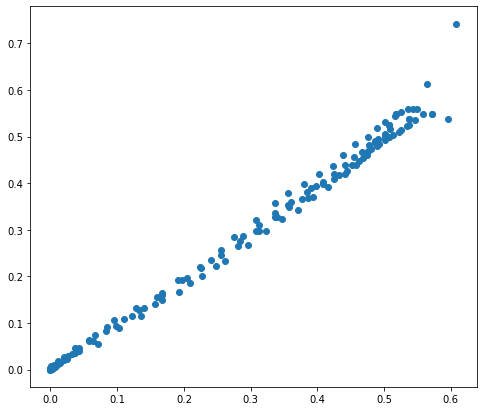

In [118]:
merge_two2=pd.merge(df_count, merge_two, on='group_name', how='inner')
for_graph=merge_two[merge_two2['loan_cnt'] > 1000]

plt.rcParams["figure.figsize"] = (8,7)
plt.scatter(for_graph['est_cumu_prepay'], for_graph['act_cumu_prepay'])

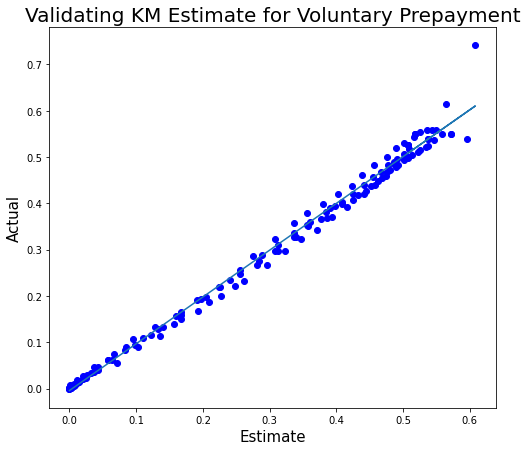

                            OLS Regression Results                            
Dep. Variable:        act_cumu_prepay   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 1.844e+04
Date:                Mon, 22 Jan 2024   Prob (F-statistic):          2.12e-161
Time:                        19:10:16   Log-Likelihood:                 401.28
No. Observations:                 155   AIC:                            -798.6
Df Residuals:                     153   BIC:                            -792.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0043      0.003     

In [119]:
x=for_graph['est_cumu_prepay']
y=for_graph['act_cumu_prepay']

plt.scatter(x, y, color='b')
plt.xlabel('Estimate', fontsize=15)
plt.ylabel('Actual', fontsize=15)
plt.title("Validating KM Estimate for Voluntary Prepayment", fontsize=20)

# add a regression line to show the relationship
m, b=np.polyfit(x, y, 1)
plt.plot(x, m*x+b)
plt.show()


# Regression analysis
import statsmodels.api as sm

# add constant to predictor variables
x = sm.add_constant(x)

# fit linear regression model
model = sm.OLS(y, x).fit()

# view model summary
print(model.summary())

# Part 5: Cox Proportional Hazards Model

In [120]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73333 entries, 0 to 104923
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   index             71586 non-null  float64 
 1   LOAN_ID           73333 non-null  int64   
 2   loan_age_bad      73333 non-null  float64 
 3   bad               73333 non-null  int64   
 4   loan_age_prepaid  73333 non-null  float64 
 5   prepaid           73333 non-null  int64   
 6   ORIG_RATE         73333 non-null  float64 
 7   CURR_RATE         73333 non-null  float64 
 8   ORIG_UPB          73333 non-null  float64 
 9   ORIG_TERM         73333 non-null  int64   
 10  OLTV              73333 non-null  int64   
 11  OCLTV             73333 non-null  int64   
 12  DTI               73333 non-null  float64 
 13  CSCORE_B          73333 non-null  float64 
 14  PURPOSE           73333 non-null  object  
 15  PROP              73333 non-null  object  
 16  STATE             733

In [121]:
df_bad['bad'].mean()

0.02353131790629408

In [122]:
from lifelines import CoxPHFitter

df_ph=df_mod[['loan_age_bad', 'bad', 'CSCORE_B', 'OLTV', 'DTI', 'ORIG_RATE', 'ORIG_UPB']]

df_mod['loan_age_bad']=np.where(df_ph['loan_age_bad'] <= 0, 1, df_ph['loan_age_bad'])
cph = CoxPHFitter()
cph.fit(df_ph, duration_col='loan_age_bad', event_col='bad')
cph.print_summary()  

/var/folders/fw/8cyt130j3w99h2qvmlbj79700000gn/T/ipykernel_21569/4011292135.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['loan_age_bad']=np.where(df_ph['loan_age_bad'] <= 0, 1, df_ph['loan_age_bad'])


<lifelines.CoxPHFitter: fitted with 73333 total observations, 71586 right-censored observations>
             duration col = 'loan_age_bad'
                event col = 'bad'
      baseline estimation = breslow
   number of observations = 73333
number of events observed = 1747
   partial log-likelihood = -18447.33
         time fit was run = 2024-01-23 01:10:18 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
CSCORE_B   -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
OLTV        0.02       1.02       0.00             0.01             0.02                 1.01                 1.02
DTI         0.04       1.04       0.00             0.03             0.05                 1.03                 1.05
ORIG_RATE   0.32       1.38       0.05             0.22             0.42                 1.25                 1.53
ORIG_UPB    0.00       1.00       0.00             0.00             0.00                 1.00                 1.00

            cmp to      z      p   -log2(p)
covariate                                  
CSCORE_B      0.00 -21.43 <0.005     335.99
OLTV          0.00   9.89 <0.005      74.14
DTI           0.00  13.26 <0.005     130.96
ORIG_RATE     0.00   6.28 <0.005      31.50
ORIG_UPB      0.00  13.91 <0.005     143.70
---
Concordance = 0.74
Partial AIC = 36904.66
log-likelihood ratio test = 1327.74 on 5 df
-log2(p) of ll-ratio test = 944.11

<AxesSubplot:xlabel='log(HR) (95% CI)'>

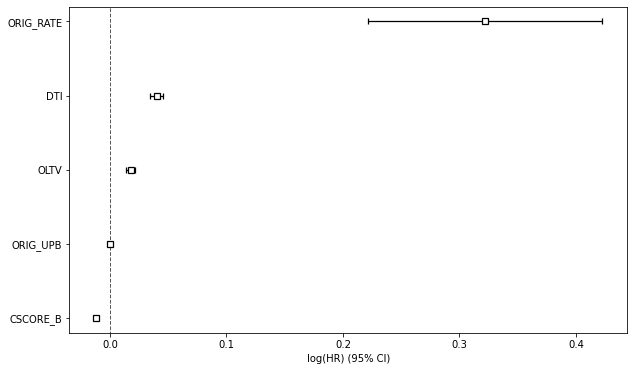

In [123]:
plt.subplots(figsize = (10, 6))
cph.plot()

<AxesSubplot:>

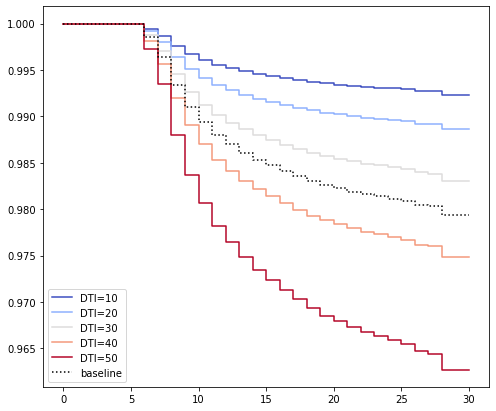

In [124]:
cph.plot_partial_effects_on_outcome(covariates = 'DTI', values = [10, 20, 30, 40, 50], cmap = 'coolwarm')

<AxesSubplot:>

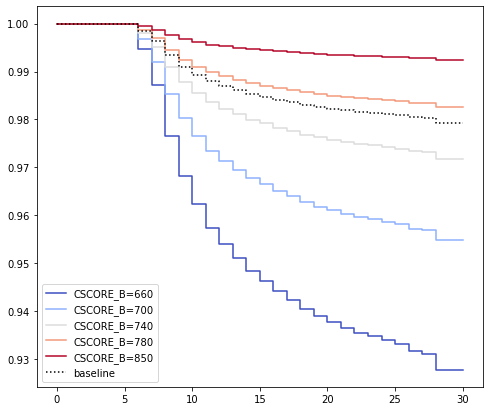

In [125]:
cph.plot_partial_effects_on_outcome(covariates = 'CSCORE_B', values = [660, 700, 740, 780, 850], cmap = 'coolwarm')

In [126]:
cph.check_assumptions(df_ph, p_value_threshold = 0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 73333 total observations, 71586 right-censored observations>
         test_name = proportional_hazard_test

---
                test_statistic      p  -log2(p)
CSCORE_B  km              0.30   0.58      0.78
          rank            0.19   0.66      0.60
DTI       km              2.11   0.15      2.77
          rank            1.98   0.16      2.65
OLTV      km              1.32   0.25      2.00
          rank            1.05   0.31      1.71
ORIG_RATE km             16.84 <0.005     14.59
          rank           12.58 <0.005     11.32
ORIG_UPB  km             12.45 <0.005     11.22
          rank           14.85 <0.005     13.07



1. Variable 'ORIG_RATE' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'ORIG_RATE' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'ORIG_RATE' using pd.cut, and then specify it in
`strata=['ORIG_RATE', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'ORIG_UPB' failed the non-proportional test: p-value is 0.0001.

   Advice 1: the functional form of the variable 'ORIG_UPB' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functi

[]

In [127]:
from lifelines.statistics import proportional_hazard_test
results = proportional_hazard_test(cph, df_ph, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 73333 total observations, 71586 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic      p  -log2(p)
CSCORE_B             0.19   0.66      0.60
DTI                  1.98   0.16      2.65
OLTV                 1.05   0.31      1.71
ORIG_RATE           12.58 <0.005     11.32
ORIG_UPB            14.85 <0.005     13.07

Next portion is to use CoxPHSurvivalAnalysis from sci-kit survival analysis package. 
Code revised from the official learning material on webpage.

In [128]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73333 entries, 0 to 104923
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   index             71586 non-null  float64 
 1   LOAN_ID           73333 non-null  int64   
 2   loan_age_bad      73333 non-null  float64 
 3   bad               73333 non-null  int64   
 4   loan_age_prepaid  73333 non-null  float64 
 5   prepaid           73333 non-null  int64   
 6   ORIG_RATE         73333 non-null  float64 
 7   CURR_RATE         73333 non-null  float64 
 8   ORIG_UPB          73333 non-null  float64 
 9   ORIG_TERM         73333 non-null  int64   
 10  OLTV              73333 non-null  int64   
 11  OCLTV             73333 non-null  int64   
 12  DTI               73333 non-null  float64 
 13  CSCORE_B          73333 non-null  float64 
 14  PURPOSE           73333 non-null  object  
 15  PROP              73333 non-null  object  
 16  STATE             733

In [129]:
df_mod[['CSCORE_B', 'OLTV', 'DTI', 'ORIG_RATE', 'ORIG_UPB']]

,CSCORE_B,OLTV,DTI,ORIG_RATE,ORIG_UPB
0,796.0,75,38.0,3.375,308000.0
1,806.0,66,25.0,3.625,207000.0
3,789.0,79,39.0,3.750,286000.0
4,681.0,78,43.0,3.990,222000.0
5,769.0,79,43.0,3.999,243000.0
...,...,...,...,...,...
104918,763.0,95,41.0,3.500,276000.0
104919,755.0,78,30.0,3.875,260000.0
104920,772.0,97,40.0,3.625,170000.0
104922,766.0,97,31.0,3.990,315000.0


In [130]:
df_mod['status']=df_mod['bad'].map({1: True, 0: False})
df_mod[['status', 'loan_age_bad']]

/var/folders/fw/8cyt130j3w99h2qvmlbj79700000gn/T/ipykernel_21569/1370815598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['status']=df_mod['bad'].map({1: True, 0: False})


,status,loan_age_bad
0,False,9.0
1,False,7.0
3,False,25.0
4,False,26.0
5,False,25.0
...,...,...
104918,True,6.0
104919,True,13.0
104920,True,8.0
104922,True,6.0


In [131]:
data_x = df_mod[['CSCORE_B', 'OLTV', 'DTI', 'ORIG_RATE', 'ORIG_UPB']]

#data_x is already numerical so no need to convert with one hot encoding.

#if data_x is categorical, use one hot encoding below to transform and feed data_x_numeric to model instead

#from sksurv.preprocessing import OneHotEncoder

#data_x_numeric = OneHotEncoder().fit_transform(data_x)
#data_x_numeric.head()

In [132]:
data_y = df_mod[['status', 'loan_age_bad']].to_numpy()
data_y

array([[False, 9.0],
       [False, 7.0],
       [False, 25.0],
       ...,
       [True, 8.0],
       [True, 6.0],
       [True, 8.0]], dtype=object)

In [133]:
#Convert data_y to the data format that model example takes

#List of tuples
aux = [(e1,e2) for e1,e2 in data_y]
#Structured array
new_data_y = np.array(aux, dtype=[('Status', '?'), ('GoodStanding_in_months', '<f8')])
data_y = new_data_y.copy()


In [134]:
data_y

array([(False,  9.), (False,  7.), (False, 25.), ..., ( True,  8.),
       ( True,  6.), ( True,  8.)],
      dtype=[('Status', '?'), ('GoodStanding_in_months', '<f8')])

In [135]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
# Which variable is most predictive?

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m=CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x.values, data_y)
pd.Series(scores, index=data_x.columns).sort_values(ascending=False)

CSCORE_B     0.673922
DTI          0.635912
OLTV         0.605726
ORIG_RATE    0.603056
ORIG_UPB     0.586588
dtype: float64

Text(0.5, 0, 'time $t$')

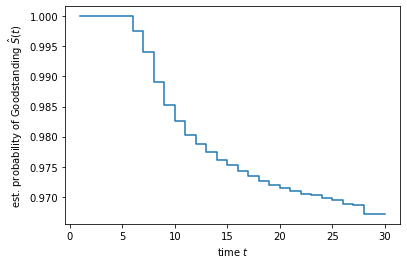

In [136]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["GoodStanding_in_months"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of Goodstanding $\hat{S}(t)$")
plt.xlabel("time $t$")

In [137]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73333 entries, 0 to 104923
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   index             71586 non-null  float64 
 1   LOAN_ID           73333 non-null  int64   
 2   loan_age_bad      73333 non-null  float64 
 3   bad               73333 non-null  int64   
 4   loan_age_prepaid  73333 non-null  float64 
 5   prepaid           73333 non-null  int64   
 6   ORIG_RATE         73333 non-null  float64 
 7   CURR_RATE         73333 non-null  float64 
 8   ORIG_UPB          73333 non-null  float64 
 9   ORIG_TERM         73333 non-null  int64   
 10  OLTV              73333 non-null  int64   
 11  OCLTV             73333 non-null  int64   
 12  DTI               73333 non-null  float64 
 13  CSCORE_B          73333 non-null  float64 
 14  PURPOSE           73333 non-null  object  
 15  PROP              73333 non-null  object  
 16  STATE             733

In [138]:
df_mod.head()

,index,LOAN_ID,loan_age_bad,bad,loan_age_prepaid,prepaid,ORIG_RATE,CURR_RATE,ORIG_UPB,ORIG_TERM,...,random,seg,fico_band,upb_band,status,property_type,rate_bin1,rate_bin2,DTI_bin,DTI & FICO
0,1107557.0,98836742,9.0,0,10.0,1,3.375,3.375,308000.0,180,...,0.418810,mod,781-820,300K - 500K,False,Single Family Home,"(2.374, 3.5]","(3.2, 4.025]",30.01% - 40%,DTI:30.01% - 40% / FICO:781-820
1,7.0,98836743,7.0,0,8.0,1,3.625,3.625,207000.0,240,...,0.753384,mod,820+,200K - 300K,False,Single Family Home,"(3.5, 3.75]","(3.2, 4.025]",20.01% - 30%,DTI:20.01% - 30% / FICO:820+
3,1586592.0,98836781,25.0,0,25.0,0,3.750,3.750,286000.0,360,...,0.573129,mod,781-820,200K - 300K,False,Single Family Home,"(3.5, 3.75]","(3.2, 4.025]",30.01% - 40%,DTI:30.01% - 40% / FICO:781-820
4,1107585.0,98836789,26.0,0,26.0,0,3.990,3.990,222000.0,360,...,0.962968,mod,661-700,200K - 300K,False,Single Family Home,"(3.875, 4.036]","(3.2, 4.025]",40%+,DTI:40%+ / FICO:661-700
5,1586619.0,98836796,25.0,0,25.0,0,3.999,3.999,243000.0,360,...,0.918518,mod,741-780,200K - 300K,False,Single Family Home,"(3.875, 4.036]","(3.2, 4.025]",40%+,DTI:40%+ / FICO:741-780


In [139]:
df_mod.groupby('PURPOSE').count()

,index,LOAN_ID,loan_age_bad,bad,loan_age_prepaid,prepaid,ORIG_RATE,CURR_RATE,ORIG_UPB,ORIG_TERM,...,random,seg,fico_band,upb_band,status,property_type,rate_bin1,rate_bin2,DTI_bin,DTI & FICO
PURPOSE,,,,,,,,,,,,,,,,,,,,,
C,18217,18632,18632,18632,18632,18632,18632,18632,18632,18632,...,18632,18632,18632,18632,18632,18632,18632,18632,18632,18632
P,25315,26058,26058,26058,26058,26058,26058,26058,26058,26058,...,26058,26058,26058,26058,26058,26058,26058,26058,26058,26058
R,28054,28643,28643,28643,28643,28643,28643,28643,28643,28643,...,28643,28643,28643,28643,28643,28643,28643,28643,28643,28643


In [140]:
data_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73333 entries, 0 to 104923
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CSCORE_B   73333 non-null  float64
 1   OLTV       73333 non-null  int64  
 2   DTI        73333 non-null  float64
 3   ORIG_RATE  73333 non-null  float64
 4   ORIG_UPB   73333 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 5.4 MB


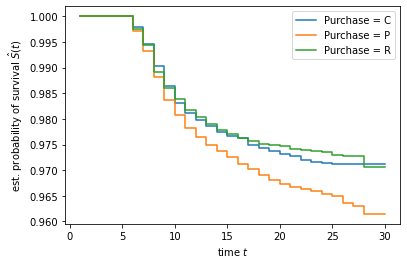

In [141]:
for purchase_type in ("C", "P", "R"):
    mask_purchase = df_mod["PURPOSE"] == purchase_type
    time_purchase, survival_prob_purchase = kaplan_meier_estimator(
        data_y["Status"][mask_purchase],
        data_y["GoodStanding_in_months"][mask_purchase])

    plt.step(time_purchase, survival_prob_purchase, where="post",
             label="Purchase = %s" % purchase_type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

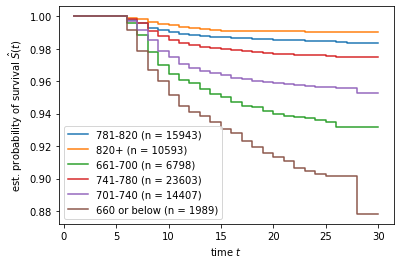

In [142]:
for value in df_mod["fico_band"].unique():
    mask = df_mod["fico_band"] == value
    time_ficoband, survival_prob_ficoband = kaplan_meier_estimator(data_y["Status"][mask],
                                                           data_y["GoodStanding_in_months"][mask])
    plt.step(time_ficoband, survival_prob_ficoband, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [143]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)

pd.Series(estimator.coef_, index=data_x.columns)

CSCORE_B    -0.012029
OLTV         0.017587
DTI          0.039866
ORIG_RATE    0.320913
ORIG_UPB     0.000003
dtype: float64

In [144]:
data_x.head()


,CSCORE_B,OLTV,DTI,ORIG_RATE,ORIG_UPB
0,796.0,75,38.0,3.375,308000.0
1,806.0,66,25.0,3.625,207000.0
3,789.0,79,39.0,3.750,286000.0
4,681.0,78,43.0,3.990,222000.0
5,769.0,79,43.0,3.999,243000.0


In [145]:
# Mock some new samples - feed to DataX for prediction - copy format from tx example
x_new = pd.DataFrame.from_dict({
    1: [845.0, 73, 42.0, 3.625, 215000.0],
    2: [766.0, 73, 42.0, 2.625, 700000.0],
    3: [770.0, 95, 60.0, 5.625, 700000.0],
    4: [768.0, 74, 37.0, 3.875, 250000.0]},
     columns=data_x.columns, orient='index')
x_new

,CSCORE_B,OLTV,DTI,ORIG_RATE,ORIG_UPB
1,845.0,73,42.0,3.625,215000.0
2,766.0,73,42.0,2.625,700000.0
3,770.0,95,60.0,5.625,700000.0
4,768.0,74,37.0,3.875,250000.0


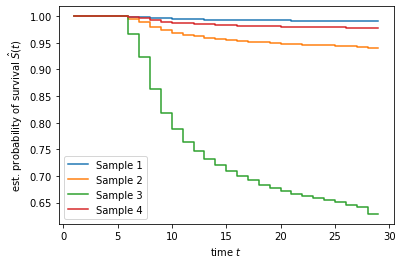

In [146]:
import numpy as np

pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(1, 30)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [147]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x)
result = concordance_index_censored(data_y["Status"], data_y["GoodStanding_in_months"], prediction)
result[0]

0.7360058014573874

In [148]:
import numpy as np

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x.values, data_y)
pd.Series(scores, index=data_x.columns).sort_values(ascending=False)

CSCORE_B     0.673922
DTI          0.635912
OLTV         0.605726
ORIG_RATE    0.603056
ORIG_UPB     0.586588
dtype: float64

In [149]:
data_y

array([(False,  9.), (False,  7.), (False, 25.), ..., ( True,  8.),
       ( True,  6.), ( True,  8.)],
      dtype=[('Status', '?'), ('GoodStanding_in_months', '<f8')])

In [150]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sksurv.preprocessing import OneHotEncoder

pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [151]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {'select__k': np.arange(1, data_x.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(data_x, data_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
4,5,{'select__k': 5},0.743908,0.728463,0.732313,0.734895,0.006565,1,0.732170,0.739537,0.736854,0.736187,0.003044
3,4,{'select__k': 4},0.730531,0.724700,0.710550,0.721927,0.008390,2,0.713142,0.737786,0.723306,0.724745,0.010112
2,3,{'select__k': 3},0.714874,0.712581,0.694687,0.707381,0.009024,3,0.699377,0.720970,0.709530,0.709959,0.008820
1,2,{'select__k': 2},0.715580,0.698965,0.692318,0.702288,0.009783,4,0.696015,0.704310,0.707500,0.702608,0.004841
0,1,{'select__k': 1},0.679376,0.675863,0.666184,0.673808,0.005578,5,0.671105,0.672914,0.677662,0.673893,0.002765


In [152]:
pipe.set_params(**gcv.best_params_)
pipe.fit(data_x, data_y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

CSCORE_B    -0.012029
OLTV         0.017587
DTI          0.039866
ORIG_RATE    0.320913
ORIG_UPB     0.000003
dtype: float64